## Описание задачи

На порталах с объявлениями о работе нередко встречаются вакансии без указания заработной платы. Часто хочется узнать, на какую зарплату можно претендовать по описанию вакансии. Также в описании вакансии содержатся ключевые навыки кандидата - полезно их автоматически анализировать и делать выводы.

Возможные задачи:
- Скачать объявления с сайта
- По набору ключевых навыков:
    -  вывести вакансии, содержащие эти навыки;
    -  вывести среднюю зарплату по таким вакансиям;
    -  вывести среднюю зарплату по всем вакансиям, содержащим каждый из перечисленных навыков.
- Собрать по всем вакансиям с одинаковыми названиям (например, ML engineer) список навыков и для каждого навыка вывести среднюю зп по всем вакансиям, содержащим такой навык. Упорядочить навыки по убыванию средней зп.
- Обучить модель ML, предсказывающую зп по описанию вакансии
- Обучить модель DL, предсказывающую зп по описанию вакансии
- Построить визуализацию вакансий по требуемому запросу (облако вакансий: кластеры - вакансии по разным направлениям, либо по схожим навыкам, либо по зп)
- Динамика изменения зп и изменения ключевых навыков во времени (возможно, нужно парсить не только hh).
- Обучить модель ML для кластеризации вакансий
- Обучить модель DL для определения числового вектора вакансии. Можно потом искать вакансию, наиболее похожую на заданное описание.

## Импорты, константы и функции

In [196]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="dark")
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from scipy import stats
from scipy.stats import kstest, kruskal, ttest_ind

from phik.report import plot_correlation_matrix
from phik.binning import bin_data

from geopy.distance import distance

In [197]:
######################################################## nan_plot ##############################################################

def nan_plot(data):

    '''Визуализация NaN значений в таблице'''
    
    nan_dict = {}
    for column in data:
        nan_dict[column] = data[column].isna().sum() / data.shape[0]

    df_nan = pd.DataFrame(data=list(nan_dict.values()),
                          index=list(nan_dict.keys()),
                          columns=['Процент пропущенных значений'])


    ### Построим barplot с NaN значениями
    plt.figure(figsize=(25,13))

    plots = sns.barplot(data=df_nan,
                        x=list(df_nan.index),
                        y = 'Процент пропущенных значений',
                        palette = 'coolwarm')
    plt.title(f'Процент и количество пропущенных значений в данных', fontsize=18)
    plt.xticks(rotation=90)
    
    ### Поставим annot
    i = 0
    for bar in plots.patches:
        plots.annotate(format(bar.get_height(), '.0%'),
                       (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                       size=5, xytext=(0, 8),
                       textcoords='offset points')
        i += 1
    
    plt.show()

    return df_nan

## Знакомство с данными

In [198]:
df = pd.read_csv('../dataset/vacancies.csv')
df = df.dropna(axis=1, how='all')

print('*' * 70)
print()
print(f'Было найдено {df.shape[0]} вакансий с появлением {df.duplicated().sum()} строк-дубликатов.')
print(f'В каждой вакансии {df.shape[1]} переменных.')
print()
print('*' * 70)
print()
display(df.info(memory_usage='deep'))
print()
print('*' * 70)
print()
display(df.describe(include='all'))
print()
print('*' * 70)
print()
display(df.sample(5))

df.drop_duplicates(inplace=True)

**********************************************************************

Было найдено 709572 вакансий с появлением 4 строк-дубликатов.
В каждой вакансии 122 переменных.

**********************************************************************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709572 entries, 0 to 709571
Columns: 122 entries, id to immediate_redirect_vacancy_id
dtypes: bool(8), float64(41), int64(3), object(70)
memory usage: 3.5 GB


None


**********************************************************************



,id,premium,name,has_test,response_letter_required,area_id,area_name,area_url,salary_from,salary_to,salary_currency,salary_gross,type_id,type_name,address_city,address_street,address_building,address_lat,address_lng,address_raw,address_metro_station_name,address_metro_line_name,address_metro_station_id,address_metro_line_id,address_metro_lat,address_metro_lng,address_metro_stations_0_station_name,address_metro_stations_0_line_name,address_metro_stations_0_station_id,address_metro_stations_0_line_id,address_metro_stations_0_lat,address_metro_stations_0_lng,address_metro_stations_1_station_name,address_metro_stations_1_line_name,address_metro_stations_1_station_id,address_metro_stations_1_line_id,address_metro_stations_1_lat,address_metro_stations_1_lng,address_metro_stations_2_station_name,address_metro_stations_2_line_name,address_metro_stations_2_station_id,address_metro_stations_2_line_id,address_metro_stations_2_lat,address_metro_stations_2_lng,address_id,response_url,published_at,created_at,archived,apply_alternate_url,show_logo_in_search,url,alternate_url,employer_id,employer_name,employer_url,employer_alternate_url,employer_logo_urls_240,employer_logo_urls_90,employer_logo_urls_original,employer_vacancies_url,employer_accredited_it_employer,employer_trusted,snippet_requirement,snippet_responsibility,schedule_id,schedule_name,accept_temporary,professional_roles_0_id,professional_roles_0_name,accept_incomplete_resumes,experience_id,experience_name,employment_id,employment_name,is_adv_vacancy,address_metro_stations_3_station_name,address_metro_stations_3_line_name,address_metro_stations_3_station_id,address_metro_stations_3_line_id,address_metro_stations_3_lat,address_metro_stations_3_lng,working_time_intervals_0_id,working_time_intervals_0_name,working_time_modes_0_id,working_time_modes_0_name,working_days_0_id,working_days_0_name,branding_type,branding_tariff,department_id,department_name,insider_interview_id,insider_interview_url,brand_snippet_logo,brand_snippet_logo_xs,brand_snippet_logo_scalable_default_width,brand_snippet_logo_scalable_default_height,brand_snippet_logo_scalable_default_url,brand_snippet_logo_scalable_xs_width,brand_snippet_logo_scalable_xs_height,brand_snippet_logo_scalable_xs_url,brand_snippet_picture,brand_snippet_picture_xs,brand_snippet_picture_scalable_default_width,brand_snippet_picture_scalable_default_height,brand_snippet_picture_scalable_default_url,brand_snippet_picture_scalable_xs_width,brand_snippet_picture_scalable_xs_height,brand_snippet_picture_scalable_xs_url,brand_snippet_background_color,brand_snippet_background_gradient_angle,brand_snippet_background_gradient_color_list_0_color,brand_snippet_background_gradient_color_list_0_position,brand_snippet_background_gradient_color_list_1_color,brand_snippet_background_gradient_color_list_1_position,brand_snippet_background_gradient_color_list_2_color,brand_snippet_background_gradient_color_list_2_position,brand_snippet_background_gradient_color_list_3_color,brand_snippet_background_gradient_color_list_3_position,immediate_redirect_url,immediate_redirect_vacancy_id
count,7.095720e+05,709572,709572,709572,709572,709572.000000,709572,709572,6.682740e+05,3.967090e+05,709572,709236,709572,709572,466977,432674,414765,471455.000000,471455.000000,471503,120168,120168,120168.000000,120168.000000,120168.000000,120168.000000,120168,120168,120168.000000,120168.000000,120168.000000,120168.000000,61015,61015,61015.000000,61015.000000,61015.000000,61015.000000,43451,43451,43451.000000,43451.000000,43451.000000,43451.000000,4.814000e+05,432,709572,709572,709572,709572,179079,709572,709572,7.087680e+05,709572,708768,708768,569347,569330,569698,708768,708768,709572,665590,687356,709572,709572,709572,709572.000000,709572,709572,709572,709572,709572,709572,709572,12766,12766,12766.000000,12766.000000,12766.000000,12766.000000,56481,56481,46085,46085,30705,30705,179464,13806,74648,74648,8257.000000,8257,143,143,143.000000,143.000000,143,143.000000,143.000000,143


**********************************************************************



,id,premium,name,has_test,response_letter_required,area_id,area_name,area_url,salary_from,salary_to,salary_currency,salary_gross,type_id,type_name,address_city,address_street,address_building,address_lat,address_lng,address_raw,address_metro_station_name,address_metro_line_name,address_metro_station_id,address_metro_line_id,address_metro_lat,address_metro_lng,address_metro_stations_0_station_name,address_metro_stations_0_line_name,address_metro_stations_0_station_id,address_metro_stations_0_line_id,address_metro_stations_0_lat,address_metro_stations_0_lng,address_metro_stations_1_station_name,address_metro_stations_1_line_name,address_metro_stations_1_station_id,address_metro_stations_1_line_id,address_metro_stations_1_lat,address_metro_stations_1_lng,address_metro_stations_2_station_name,address_metro_stations_2_line_name,address_metro_stations_2_station_id,address_metro_stations_2_line_id,address_metro_stations_2_lat,address_metro_stations_2_lng,address_id,response_url,published_at,created_at,archived,apply_alternate_url,show_logo_in_search,url,alternate_url,employer_id,employer_name,employer_url,employer_alternate_url,employer_logo_urls_240,employer_logo_urls_90,employer_logo_urls_original,employer_vacancies_url,employer_accredited_it_employer,employer_trusted,snippet_requirement,snippet_responsibility,schedule_id,schedule_name,accept_temporary,professional_roles_0_id,professional_roles_0_name,accept_incomplete_resumes,experience_id,experience_name,employment_id,employment_name,is_adv_vacancy,address_metro_stations_3_station_name,address_metro_stations_3_line_name,address_metro_stations_3_station_id,address_metro_stations_3_line_id,address_metro_stations_3_lat,address_metro_stations_3_lng,working_time_intervals_0_id,working_time_intervals_0_name,working_time_modes_0_id,working_time_modes_0_name,working_days_0_id,working_days_0_name,branding_type,branding_tariff,department_id,department_name,insider_interview_id,insider_interview_url,brand_snippet_logo,brand_snippet_logo_xs,brand_snippet_logo_scalable_default_width,brand_snippet_logo_scalable_default_height,brand_snippet_logo_scalable_default_url,brand_snippet_logo_scalable_xs_width,brand_snippet_logo_scalable_xs_height,brand_snippet_logo_scalable_xs_url,brand_snippet_picture,brand_snippet_picture_xs,brand_snippet_picture_scalable_default_width,brand_snippet_picture_scalable_default_height,brand_snippet_picture_scalable_default_url,brand_snippet_picture_scalable_xs_width,brand_snippet_picture_scalable_xs_height,brand_snippet_picture_scalable_xs_url,brand_snippet_background_color,brand_snippet_background_gradient_angle,brand_snippet_background_gradient_color_list_0_color,brand_snippet_background_gradient_color_list_0_position,brand_snippet_background_gradient_color_list_1_color,brand_snippet_background_gradient_color_list_1_position,brand_snippet_background_gradient_color_list_2_color,brand_snippet_background_gradient_color_list_2_position,brand_snippet_background_gradient_color_list_3_color,brand_snippet_background_gradient_color_list_3_position,immediate_redirect_url,immediate_redirect_vacancy_id
589831,108722462,False,Кассир,False,False,2759,Ташкент,https://api.hh.ru/areas/2759,3000000.0,4000000.0,UZS,False,open,Открытая,Tashkent,31 Yangizamon Str.,Tashkent,41.274084,69.293438,"Tashkent, 31 Yangizamon Str., Tashkent",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12927254.0,NaN,2024-10-16T11:02:29+0300,2024-10-16T11:02:29+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,NaN,https://api.hh.ru/vacancies/108722462?host=hh.ru,https://hh.ru/vacancy/108722462,3933870.0,ЧП Luseya Plyus,https://api.hh.ru/employers/3933870,https://hh.ru/employer/3933870,NaN,NaN,NaN,https://api.hh.ru/vacancies?employer_id=3933870,False,True,"Опыт работы на аналогичной позиции желателен, ...",Проведение расчетов с клиентами за услуги комп...,fullDay,Полный день,False,97,"Продавец-консультант, продавец-кассир",True,between1And3,От 1 года до 

После парсинга мы получили DF с 709.572 наблюдениями и 122 фичами, этого будет более, чем достаточно. В дальнейшем, возможно, понадобиться масшабирование, чтобы снизить вес данных, нынешний вес составляет 3.5 ГБ. В таблице есть категориальные, непрерывные и дискретные переменные, будем рассматривать каждый признак по отдельности. Также наш датасет имеет уйму пропусков, которые необходимо будет предобработать для некоторых моделей ML.

Стоит посмотреть на столбцы salary_from	и salary_to, которые являются нашим таргетом. В дальнейшем необходимо агрегировать два столбца, чтобы не угадывать вилку, а конкретную цифру.

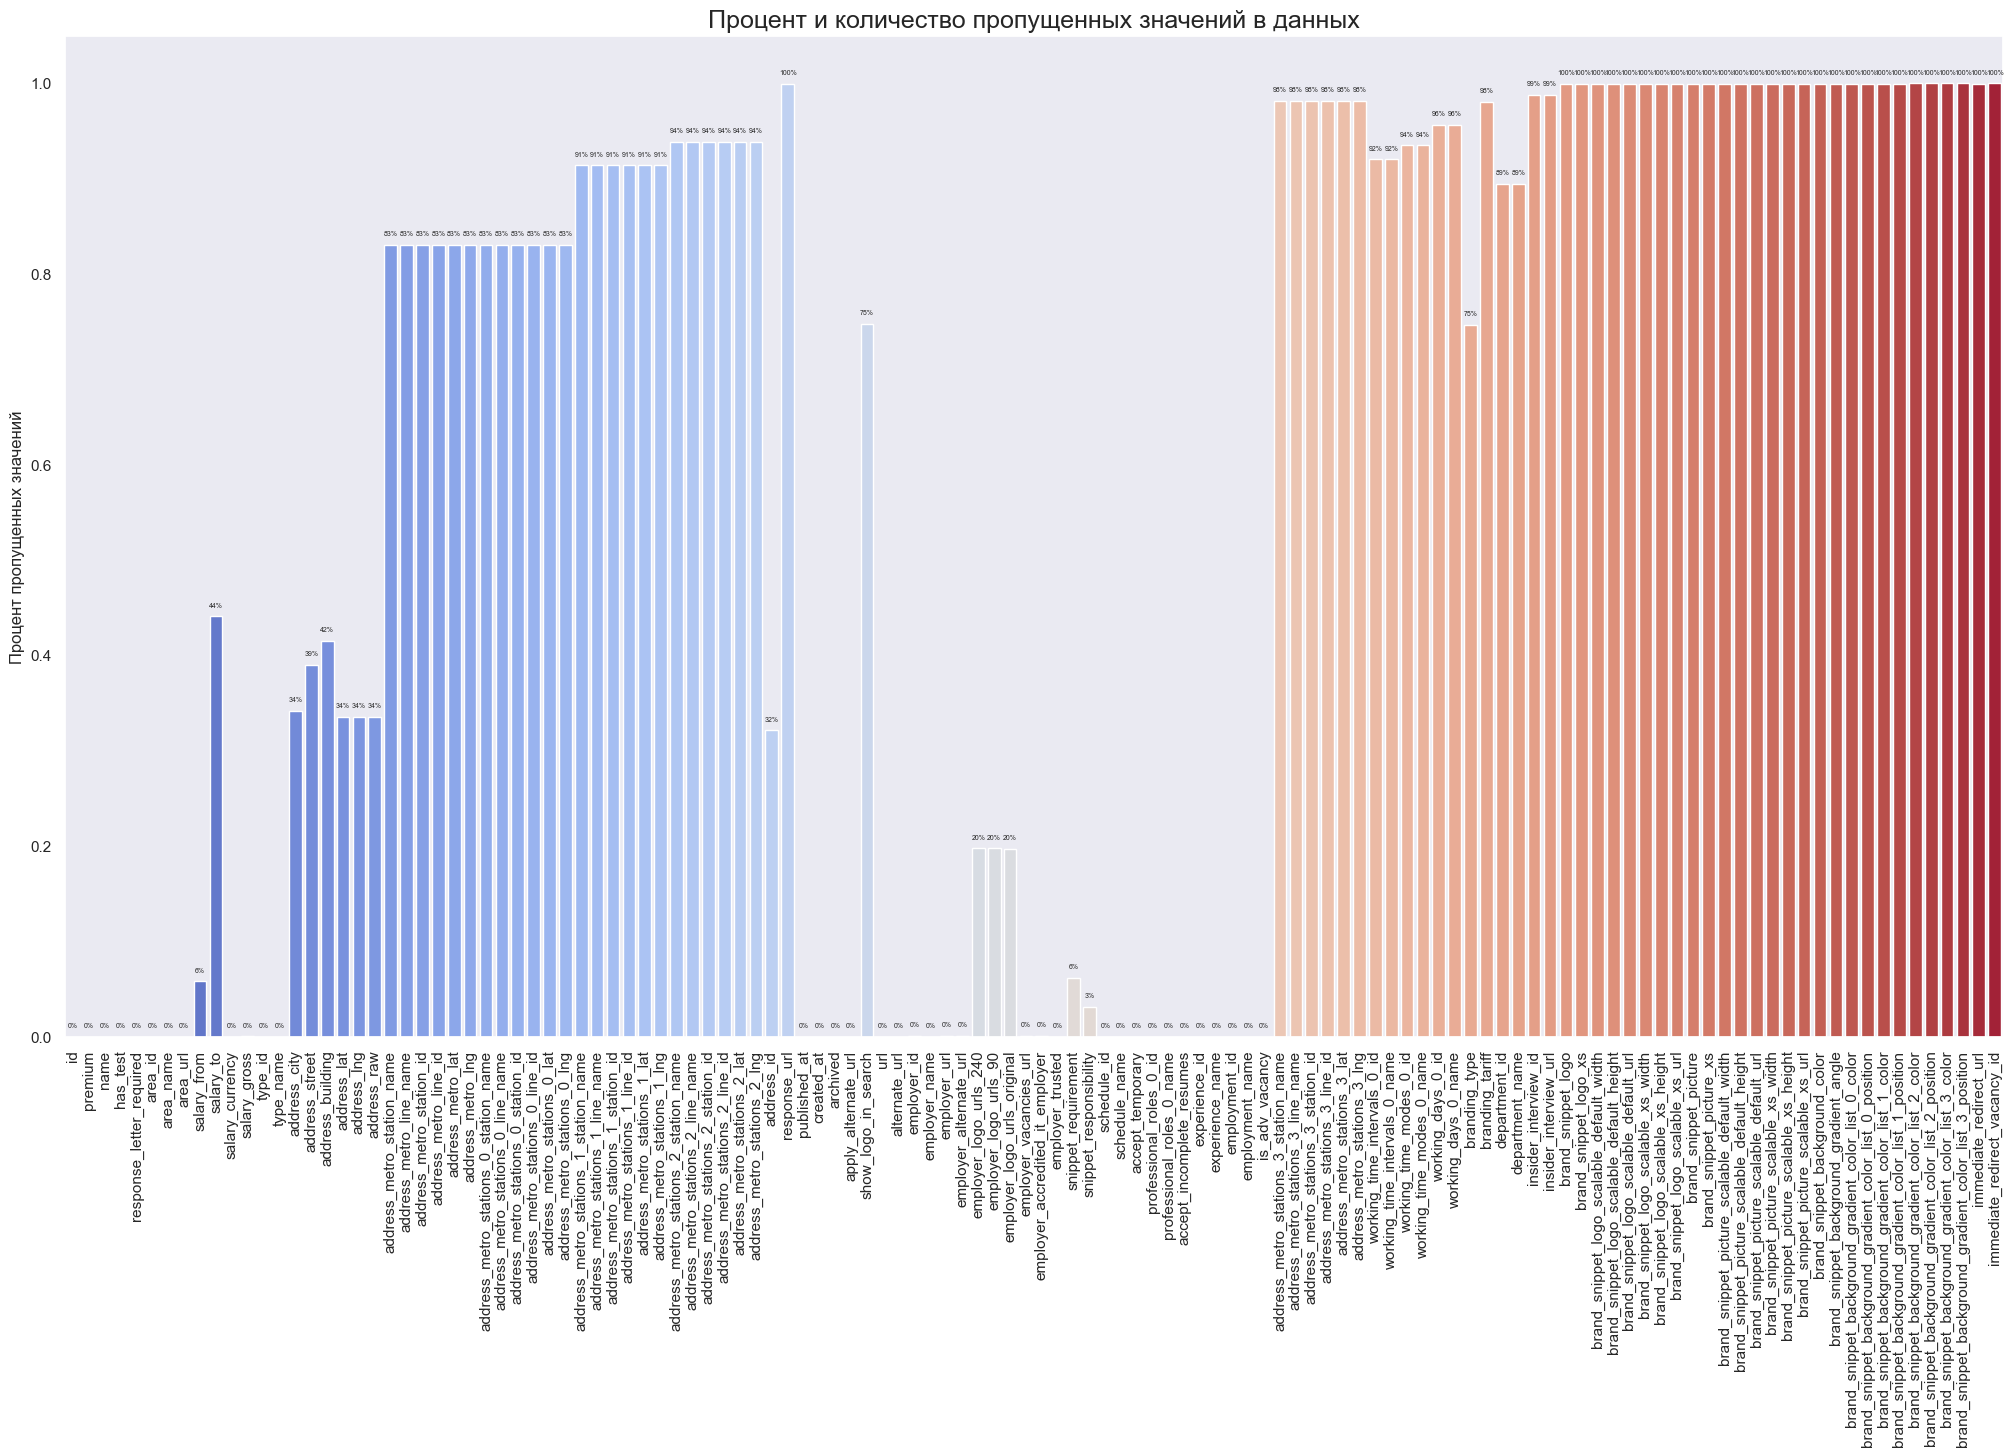

In [199]:
### Просмотр количества NaN значений по всему DF
df_nan = nan_plot(df)

Как уже говорилось, наш DF имеет достаточно много NaN значений, в некоторых столбцах доходит до 99%. Однако, что самое важное: мы имеем пропуски в заработной плате. В дальнейшем необходимо исправить пропуски в каждом столбце.

In [200]:
df

,id,premium,name,has_test,response_letter_required,area_id,area_name,area_url,salary_from,salary_to,salary_currency,salary_gross,type_id,type_name,address_city,address_street,address_building,address_lat,address_lng,address_raw,address_metro_station_name,address_metro_line_name,address_metro_station_id,address_metro_line_id,address_metro_lat,address_metro_lng,address_metro_stations_0_station_name,address_metro_stations_0_line_name,address_metro_stations_0_station_id,address_metro_stations_0_line_id,address_metro_stations_0_lat,address_metro_stations_0_lng,address_metro_stations_1_station_name,address_metro_stations_1_line_name,address_metro_stations_1_station_id,address_metro_stations_1_line_id,address_metro_stations_1_lat,address_metro_stations_1_lng,address_metro_stations_2_station_name,address_metro_stations_2_line_name,address_metro_stations_2_station_id,address_metro_stations_2_line_id,address_metro_stations_2_lat,address_metro_stations_2_lng,address_id,response_url,published_at,created_at,archived,apply_alternate_url,show_logo_in_search,url,alternate_url,employer_id,employer_name,employer_url,employer_alternate_url,employer_logo_urls_240,employer_logo_urls_90,employer_logo_urls_original,employer_vacancies_url,employer_accredited_it_employer,employer_trusted,snippet_requirement,snippet_responsibility,schedule_id,schedule_name,accept_temporary,professional_roles_0_id,professional_roles_0_name,accept_incomplete_resumes,experience_id,experience_name,employment_id,employment_name,is_adv_vacancy,address_metro_stations_3_station_name,address_metro_stations_3_line_name,address_metro_stations_3_station_id,address_metro_stations_3_line_id,address_metro_stations_3_lat,address_metro_stations_3_lng,working_time_intervals_0_id,working_time_intervals_0_name,working_time_modes_0_id,working_time_modes_0_name,working_days_0_id,working_days_0_name,branding_type,branding_tariff,department_id,department_name,insider_interview_id,insider_interview_url,brand_snippet_logo,brand_snippet_logo_xs,brand_snippet_logo_scalable_default_width,brand_snippet_logo_scalable_default_height,brand_snippet_logo_scalable_default_url,brand_snippet_logo_scalable_xs_width,brand_snippet_logo_scalable_xs_height,brand_snippet_logo_scalable_xs_url,brand_snippet_picture,brand_snippet_picture_xs,brand_snippet_picture_scalable_default_width,brand_snippet_picture_scalable_default_height,brand_snippet_picture_scalable_default_url,brand_snippet_picture_scalable_xs_width,brand_snippet_picture_scalable_xs_height,brand_snippet_picture_scalable_xs_url,brand_snippet_background_color,brand_snippet_background_gradient_angle,brand_snippet_background_gradient_color_list_0_color,brand_snippet_background_gradient_color_list_0_position,brand_snippet_background_gradient_color_list_1_color,brand_snippet_background_gradient_color_list_1_position,brand_snippet_background_gradient_color_list_2_color,brand_snippet_background_gradient_color_list_2_position,brand_snippet_background_gradient_color_list_3_color,brand_snippet_background_gradient_color_list_3_position,immediate_redirect_url,immediate_redirect_vacancy_id
0,107085827,False,Менеджер по работе с клиентами / менеджер по п...,False,False,1,Москва,https://api.hh.ru/areas/1,100000.0,150000.0,RUR,True,open,Открытая,Москва,Дербеневская набережная,7с2,55.723328,37.655508,"Москва, Дербеневская набережная, 7с2",Крестьянская застава,Люблинско-Дмитровская,10.630,10.0,55.732278,37.665325,Крестьянская застава,Люблинско-Дмитровская,10.630,10.0,55.732278,37.665325,Павелецкая,Замоскворецкая,2.101,2.0,55.729741,37.638693,Таганская,Таганско-Краснопресненская,7.770,7.0,55.739502,37.653605,16511923.0,NaN,2024-09-16T11:45:48+0300,2024-09-16T11:45:48+0300,True,https://hh.ru/applicant/vacancy_response?vacan...,NaN,https://api.hh.ru/vacancies/107085827?host=hh.ru,https://hh.ru/vacancy/107085827,2036271.0,Ищем работу вместе,https://api.hh.ru/employers/2036271,https://hh.ru/employer/2036271,https://img.hhcdn.ru/employer-logo/3457738.jpeg,https://img.hhcdn.ru/e

##### Столбец salary (target)

In [201]:
### У нас есть два толбца: salary_from и salary_to - вилка ЗП. Нам необходимо преобразовать их в один общий столбец с нашей целевой переменной

def calculate_salary(row):
    if pd.isna(row['salary_from']):
        return row['salary_to']
    if pd.isna(row['salary_to']):
        return row['salary_from']
    return (row['salary_from'] + row['salary_to']) // 2

df['salary'] = df.progress_apply(calculate_salary, axis=1)
df['salary'][:5]

100%|██████████| 709568/709568 [00:05<00:00, 135225.51it/s]


0    125000.0
1     52500.0
2     58500.0
3     75000.0
4    110000.0
Name: salary, dtype: float64

In [202]:
# Удалим "вилочные" столбцы
for column in ['salary_from', 'salary_to']:
    del df[column]

In [203]:
# Посмотрим на топ ЗП
df['salary'].sort_values(ascending=False).head(15)

159831    115000000.0
51020      76000000.0
263494     60000000.0
156332     60000000.0
527748     57500000.0
191078     52500000.0
233576     52500000.0
317316     50500000.0
96096      50000000.0
418073     50000000.0
53644      40000000.0
614959     40000000.0
86906      40000000.0
294222     38000000.0
249473     35000000.0
Name: salary, dtype: float64

In [204]:
# Посмотрим на валюты топа ЗП
df.loc[df['salary'] > 35000000, ['salary', 'salary_currency']]

,salary,salary_currency
51020,76000000.0,UZS
53644,40000000.0,UZS
86906,40000000.0,UZS
96096,50000000.0,RUR
156332,60000000.0,UZS
159831,115000000.0,UZS
191078,52500000.0,UZS
233576,52500000.0,UZS
263494,60000000.0,UZS
294222,38000000.0,UZS


Как мы можем видеть, на некоторых вакансиях ЗП указана в других валютах. Нам необходимо нормализировать зарабаток в рубли.

In [205]:
df['salary_currency'].unique()

array(['RUR', 'USD', 'EUR', 'KZT', 'BYR', 'UZS', 'AZN', 'GEL', 'KGS'],
      dtype=object)

In [206]:
# Выставляем курс на момент 22.10.24

salary_currency_dict_to_RUR = {
    'RUR': 1,
    'USD': 96.09,
    'EUR': 104.4,
    'KZT': 0.198112,
    'BYR': 29.2,
    'UZS': 0.007498,
    'AZN': 56.52,
    'GEL': 35.38,
    'KGS': 1.12
}

df['salary'] = df['salary'] * df['salary_currency'].map(salary_currency_dict_to_RUR)

In [207]:
df.loc[df['salary'] > 4600000]

,id,premium,name,has_test,response_letter_required,area_id,area_name,area_url,salary_currency,salary_gross,type_id,type_name,address_city,address_street,address_building,address_lat,address_lng,address_raw,address_metro_station_name,address_metro_line_name,address_metro_station_id,address_metro_line_id,address_metro_lat,address_metro_lng,address_metro_stations_0_station_name,address_metro_stations_0_line_name,address_metro_stations_0_station_id,address_metro_stations_0_line_id,address_metro_stations_0_lat,address_metro_stations_0_lng,address_metro_stations_1_station_name,address_metro_stations_1_line_name,address_metro_stations_1_station_id,address_metro_stations_1_line_id,address_metro_stations_1_lat,address_metro_stations_1_lng,address_metro_stations_2_station_name,address_metro_stations_2_line_name,address_metro_stations_2_station_id,address_metro_stations_2_line_id,address_metro_stations_2_lat,address_metro_stations_2_lng,address_id,response_url,published_at,created_at,archived,apply_alternate_url,show_logo_in_search,url,alternate_url,employer_id,employer_name,employer_url,employer_alternate_url,employer_logo_urls_240,employer_logo_urls_90,employer_logo_urls_original,employer_vacancies_url,employer_accredited_it_employer,employer_trusted,snippet_requirement,snippet_responsibility,schedule_id,schedule_name,accept_temporary,professional_roles_0_id,professional_roles_0_name,accept_incomplete_resumes,experience_id,experience_name,employment_id,employment_name,is_adv_vacancy,address_metro_stations_3_station_name,address_metro_stations_3_line_name,address_metro_stations_3_station_id,address_metro_stations_3_line_id,address_metro_stations_3_lat,address_metro_stations_3_lng,working_time_intervals_0_id,working_time_intervals_0_name,working_time_modes_0_id,working_time_modes_0_name,working_days_0_id,working_days_0_name,branding_type,branding_tariff,department_id,department_name,insider_interview_id,insider_interview_url,brand_snippet_logo,brand_snippet_logo_xs,brand_snippet_logo_scalable_default_width,brand_snippet_logo_scalable_default_height,brand_snippet_logo_scalable_default_url,brand_snippet_logo_scalable_xs_width,brand_snippet_logo_scalable_xs_height,brand_snippet_logo_scalable_xs_url,brand_snippet_picture,brand_snippet_picture_xs,brand_snippet_picture_scalable_default_width,brand_snippet_picture_scalable_default_height,brand_snippet_picture_scalable_default_url,brand_snippet_picture_scalable_xs_width,brand_snippet_picture_scalable_xs_height,brand_snippet_picture_scalable_xs_url,brand_snippet_background_color,brand_snippet_background_gradient_angle,brand_snippet_background_gradient_color_list_0_color,brand_snippet_background_gradient_color_list_0_position,brand_snippet_background_gradient_color_list_1_color,brand_snippet_background_gradient_color_list_1_position,brand_snippet_background_gradient_color_list_2_color,brand_snippet_background_gradient_color_list_2_position,brand_snippet_background_gradient_color_list_3_color,brand_snippet_background_gradient_color_list_3_position,immediate_redirect_url,immediate_redirect_vacancy_id,salary
11439,108051087,False,Менеджер в департамент продаж международной не...,False,False,1,Москва,https://api.hh.ru/areas/1,RUR,False,open,Открытая,Москва,улица Ленинская Слобода,26с5,55.711201,37.652836,"Москва, улица Ленинская Слобода, 26с5",Автозаводская,Замоскворецкая,2.200,2.0,55.706634,37.657008,Автозаводская,Замоскворецкая,2.200,2.0,55.706634,37.657008,Автозаводская,МЦК,95.530,95.0,55.706310,37.663140,NaN,NaN,NaN,NaN,NaN,NaN,15996434.0,NaN,2024-10-02T12:43:54+0300,2024-10-02T12:43:54+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,True,https://api.hh.ru/vacancies/108051087?host=hh.ru,https://hh.ru/vacancy/108051087,1303772.0,ЭстэйтЛига,https://api.hh.ru/employers/1303772,https://hh.ru/employer/1303772,https://img.hhcdn.ru/employer-logo/5646061.png,https://img.hhcdn.ru/employer-logo/5646060.png,https://img.hhcdn.ru/employer-logo-original/10...,https://api.hh.ru/vacancies?employer_id

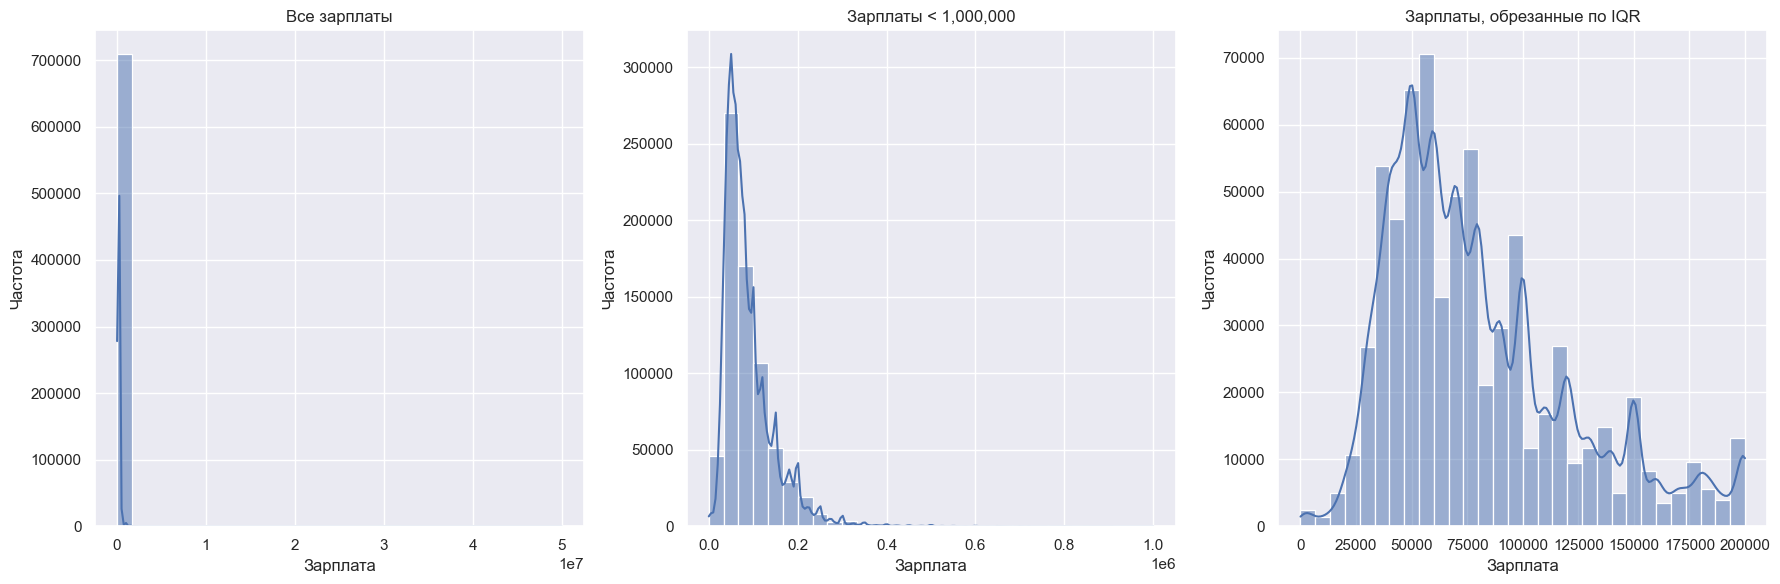

In [208]:
Q1 = df['salary'].quantile(0.25)
Q3 = df['salary'].quantile(0.75)
IQR = Q3 - Q1

df_iqr = df[(df['salary'] >= Q1 - 1.5 * IQR) & (df['salary'] <= Q3 + 1.5 * IQR)]

plt.figure(figsize=(18, 6))

#Все зарплаты
plt.subplot(1, 3, 1)
sns.histplot(df['salary'], bins=30, kde=True)
plt.grid(True)
plt.title('Все зарплаты')
plt.xlabel('Зарплата')
plt.ylabel('Частота')

#Зарплаты < 1 000 000
plt.subplot(1, 3, 2)
sns.histplot(df.loc[df['salary'] < 1000000, 'salary'], bins=30, kde=True)
plt.grid(True)
plt.title('Зарплаты < 1,000,000')
plt.xlabel('Зарплата')
plt.ylabel('Частота')

#Зарплаты, обрезанные по IQR
plt.subplot(1, 3, 3)
sns.histplot(df_iqr['salary'], bins=30, kde=True)
plt.grid(True)
plt.title('Зарплаты, обрезанные по IQR')
plt.xlabel('Зарплата')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

In [209]:
# Посмотрим нормальность распределение без ассиметрии 

salary = df['salary']
mean = np.mean(salary)
std = np.std(salary)
stat, p_value = kstest(salary, 'norm', args=(mean, std))
print(f'K-S Test Статистика: {stat}, p-value: {p_value}')

# Интерпретация результата
alpha = 0.05
if p_value > alpha:
    print('Убедительных доказательств против гипотезы о нормальности нет (не отвергаем H0)')
else:
    print('Гипотеза о нормальности отвергается (отвергаем H0)')

K-S Test Статистика: 0.23989213789786568, p-value: 0.0
Гипотеза о нормальности отвергается (отвергаем H0)


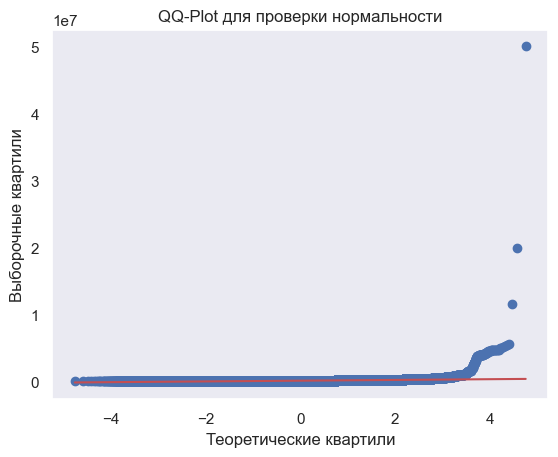

In [210]:
# Докажем ещё одним способом
fig = plt.figure()
ax = fig.add_subplot(111)
stats.probplot(salary, dist="norm", plot=ax)
ax.get_lines()[1].set_color('r')
ax.set_title('QQ-Plot для проверки нормальности')
ax.set_xlabel('Теоретические квартили')
ax.set_ylabel('Выборочные квартили')
plt.show()

Был добавлен новый столбец - salary, целевая переменная путём усреднения данных столбцов salary_from и salary_to (0% NaN). Также некоторые ЗП были указаны в других валютах, необходимо было перевести на RUR.

В данных есть выбросы: ЗП по 3-9 млн. рублей, в дальнейшем никак не будем их удалять - информация является достоверной, указанной на сайте HH. Большинство вакансий с такой вилкой - агенты по недвижимости.

Целевая переменная имеет вид нормального распределения с правосторонней ассиметрией. В дальнейшем можно попробовать прогогорифмировать данные, это позволить снизить выбросы и добавить линейности данным.

##### Столбец employer_accredited_it_employer

In [211]:
nan_per_employer_accredited_it_employer = df_nan.loc[df_nan.index == 'employer_accredited_it_employer', 'Процент пропущенных значений'][0]
print(f'Процент пропущенных значений в столбце employer_accredited_it_employer: {nan_per_employer_accredited_it_employer:.3%}')

Процент пропущенных значений в столбце employer_accredited_it_employer: 0.113%


Хоть процент пропущенных значений слишком мал, заполним пропуски константой Unknown, чтобы не терять информацию. В дальнейшем посмотрим влияет ли пропуск на зарплату кандидата.

In [212]:
df['employer_accredited_it_employer'].fillna('Unknown', inplace=True)

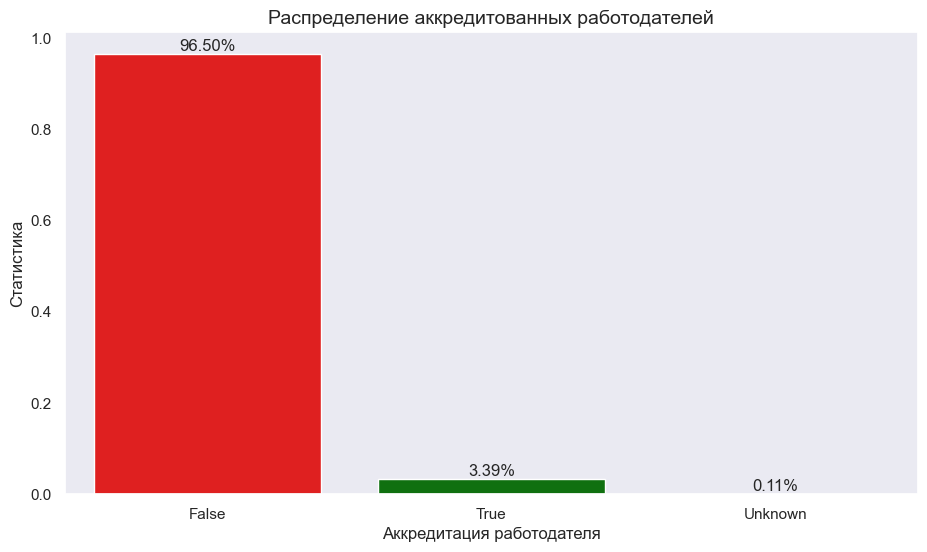

In [213]:
employer_accredited_it_employer_palette = {True: 'green', False: 'red', 'Unknown': 'black'}
f, ax = plt.subplots(figsize=(11, 6))

ax = sns.barplot(
    x=df['employer_accredited_it_employer'].value_counts(normalize=True).index,
    y=df['employer_accredited_it_employer'].value_counts(normalize=True),
    palette=employer_accredited_it_employer_palette,
    hue=df['employer_accredited_it_employer'].value_counts(normalize=True).index,
    legend=False
)
plt.title('Распределение аккредитованных работодателей', fontsize=14)
plt.xlabel('Аккредитация работодателя')
plt.ylabel('Статистика')

for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()

In [214]:
# Проверим группы на нормальность и гомогенность дисперсий, при положительном результате сделаем ANOVA тестирование

groupA = df.loc[df['employer_accredited_it_employer'] == False, 'salary']
groupB = df.loc[df['employer_accredited_it_employer'] == True, 'salary']
groupC = df.loc[df['employer_accredited_it_employer'] == 'Unknown', 'salary']

def check_normality(group, name):
    stat, p_value = stats.shapiro(group)
    print(f"Группа {name} - Тест Шапиро-Уилка: Статистика = {stat:.4f}, p-значение = {p_value:.4f}")
    if p_value > 0.05:
        print(f"Группа {name}: Данные распределены нормально.")
    else:
        print(f"Группа {name}: Данные не распределены нормально.")

check_normality(groupA, 'A')
print()
check_normality(groupB, 'B')
check_normality(groupC, 'C')

stat, p_value = stats.levene(groupA, groupB, groupC)
print(f"\nТест Левена: Статистика = {stat:.4f}, p-значение = {p_value:.4f}")
if p_value > 0.05:
    print("Дисперсии считать одинаковыми.")
else:
    print("Дисперсии считать неодинаковыми.")

Группа A - Тест Шапиро-Уилка: Статистика = 0.2984, p-значение = 0.0000
Группа A: Данные не распределены нормально.

Группа B - Тест Шапиро-Уилка: Статистика = 0.8964, p-значение = 0.0000
Группа B: Данные не распределены нормально.
Группа C - Тест Шапиро-Уилка: Статистика = 0.7347, p-значение = 0.0000
Группа C: Данные не распределены нормально.

Тест Левена: Статистика = 443.5680, p-значение = 0.0000
Дисперсии считать неодинаковыми.


In [215]:
# Посмотрим на Крускала-Уоллиса - непараметрический тест для сравнения различий двух и более выборок.

h_stat, p_value = stats.kruskal(groupA, groupB, groupC)
print(f'Kruskal-Wallis H-statistic: {h_stat}, P-value: {p_value}')

if p_value < 0.05:
    print('Есть статистически значимые различия между группами')
else:
    print('Нет статистически значимых различий между группами.')

Kruskal-Wallis H-statistic: 3847.87867762986, P-value: 0.0
Есть статистически значимые различия между группами


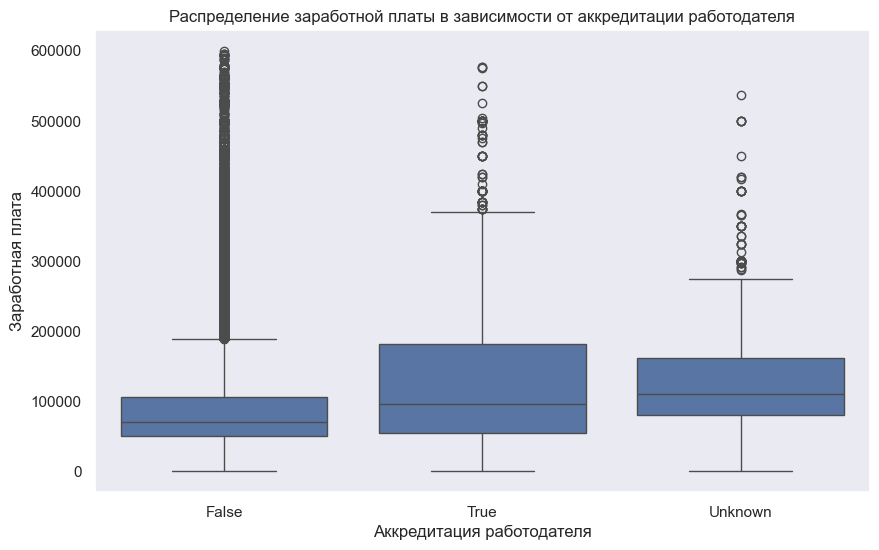

In [216]:
percentile_99 = df['salary'].quantile(0.999) # Для наглядной визуализации возьмём salary < 99.9% выборки
filtered_df = df[df['salary'] < percentile_99]

# Преобразование категориальной переменной в числовую
filtered_df['employer_accredited_it_employer_numeric'] = filtered_df['employer_accredited_it_employer'].map({True: 1, False: 0, 'Unknown': -1})

plt.figure(figsize=(10, 6))
sns.boxplot(x='employer_accredited_it_employer', y='salary', data=filtered_df)
plt.title('Распределение заработной платы в зависимости от аккредитации работодателя')
plt.xlabel('Аккредитация работодателя')
plt.ylabel('Заработная плата')
plt.show()

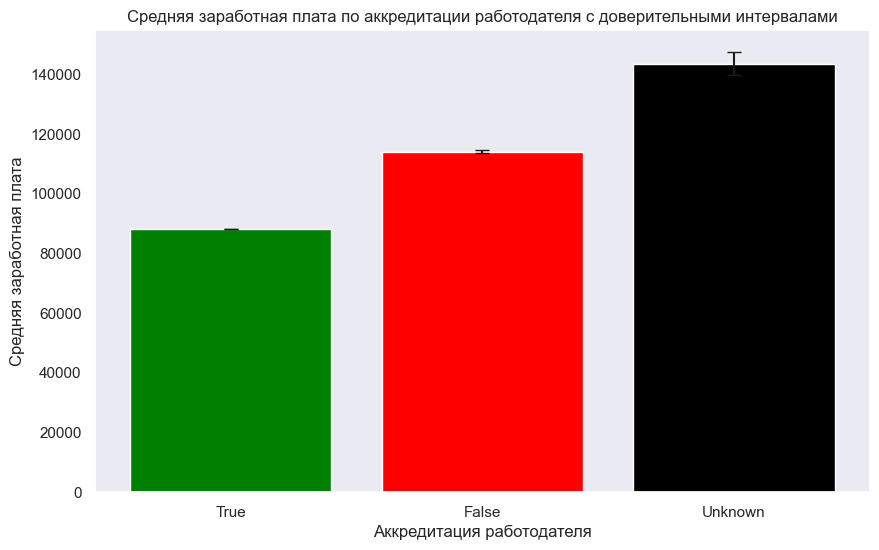

In [217]:
# Вычисляем средние значения и стандартные ошибки каждой группы
means = [
    np.mean(groupA),
    np.mean(groupB),
    np.mean(groupC)
]

std_errors = [
    stats.sem(groupA),
    stats.sem(groupB),
    stats.sem(groupC)
]

groups = ['True', 'False', 'Unknown']

plt.figure(figsize=(10, 6))
plt.bar(groups, means, yerr=std_errors, capsize=5, color=['green', 'red', 'black'])
plt.title('Средняя заработная плата по аккредитации работодателя с доверительными интервалами')
plt.xlabel('Аккредитация работодателя')
plt.ylabel('Средняя заработная плата')
plt.show()

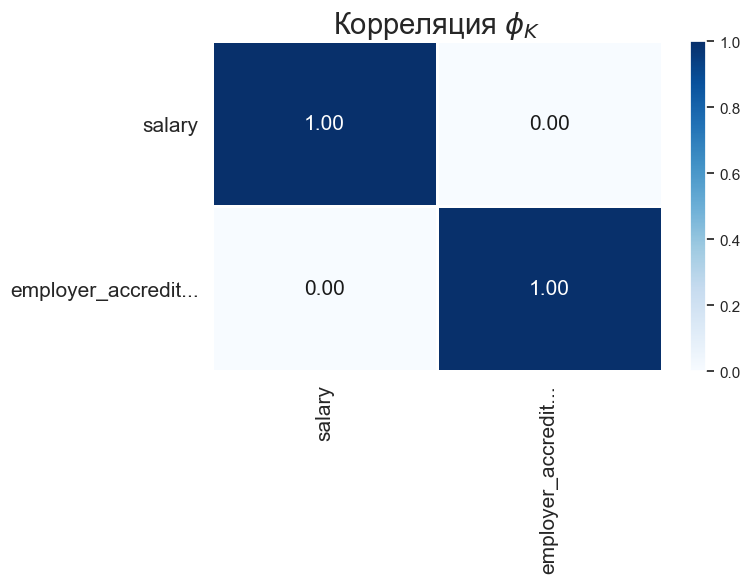

In [218]:
# Воспользуемся корреляцией Phik
binned_df = bin_data(df[['employer_accredited_it_employer', 'salary']].copy(), bins=100, cols=['salary'])

phik_overview = binned_df.phik_matrix(interval_cols=['salary'])
phik_overview.round(5)

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Blues",
                        title=r"Корреляция $\phi_K$",
                        fontsize_factor=1.5,
                        figsize=(8, 6))
plt.tight_layout()
plt.show()

Столбец employer_accredited_it_employer содержит в себе информацию об аккредитации компании. Object, можно перевести в int, чтобы понизить вес данных. В данных было 0.113% пропусков - заменили на константу Unknown. Большинство работодателей (~97%) не имею аккредитации, что влияет на медианную ЗП, которую платит работодатель:
-   С аккредитацией: медиана равна 96.242 рублей, 50% данных находится в диапазоне от ~60к до ~ 180к, максимальное значение усов доходит до ~360к. Есть выбросы;
-   Без аккредитации: медиана равна 70.000 рублей, 50% данных находится в диапазоне от ~50к до ~ 110к, максимальное значение усов доходит до ~200к. Есть выбросы;
-   Без уточения аккредитации: медиана равна 110.000 рублей, 50% данных находится в диапазоне от ~80к до ~ 160к, максимальное значение усов доходит до ~360к. Есть выбросы.

Тест Крускала-Уоллиса доказал, что есть статистически значимые различия между тремя группами, также доверительные интервалы средних значений различны. Зависимость через корреляцию Phik не была выявлена.

In [219]:
artem_columns = df.columns[61: 92]
artem_columns

Index(['snippet_requirement', 'snippet_responsibility', 'schedule_id',
       'schedule_name', 'accept_temporary', 'professional_roles_0_id',
       'professional_roles_0_name', 'accept_incomplete_resumes',
       'experience_id', 'experience_name', 'employment_id', 'employment_name',
       'is_adv_vacancy', 'address_metro_stations_3_station_name',
       'address_metro_stations_3_line_name',
       'address_metro_stations_3_station_id',
       'address_metro_stations_3_line_id', 'address_metro_stations_3_lat',
       'address_metro_stations_3_lng', 'working_time_intervals_0_id',
       'working_time_intervals_0_name', 'working_time_modes_0_id',
       'working_time_modes_0_name', 'working_days_0_id', 'working_days_0_name',
       'branding_type', 'branding_tariff', 'department_id', 'department_name',
       'insider_interview_id', 'insider_interview_url'],
      dtype='object')

##### Столбец schedule_id и schedule_name

In [220]:
df['schedule_id'].unique()

array(['fullDay', 'shift', 'remote', 'flexible', 'flyInFlyOut'],
      dtype=object)

In [221]:
df['schedule_name'].unique()

array(['Полный день', 'Сменный график', 'Удаленная работа',
       'Гибкий график', 'Вахтовый метод'], dtype=object)

In [222]:
df[['schedule_id', 'schedule_name']].head()

,schedule_id,schedule_name
0,fullDay,Полный день
1,shift,Сменный график
2,shift,Сменный график
3,remote,Удаленная работа
4,fullDay,Полный день


Можем заметить, что данные столбцы несут в себе одну и ту же информацию - удалим один из них для избежания мультикорреляции, а также понизим масштаб данных.

In [223]:
del df['schedule_id']

In [224]:
nan_schedule_name = df['schedule_name'].isna().sum()
print(f'Колчиество NaN объектов: {nan_schedule_name}')

Колчиество NaN объектов: 0


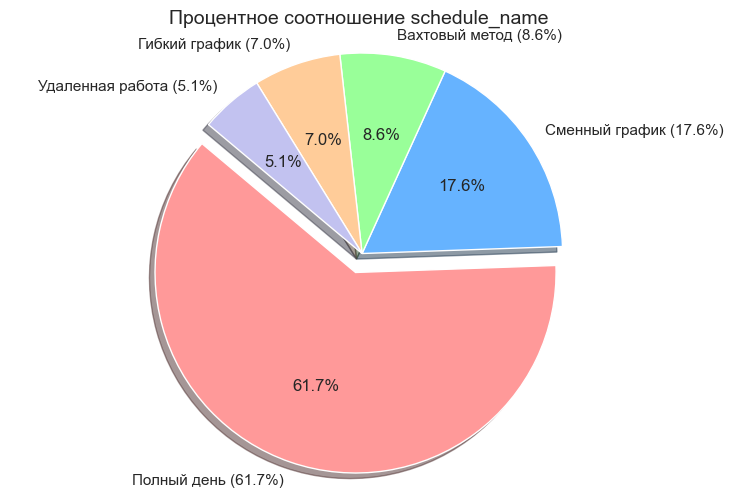

In [225]:
count_series = df['schedule_name'].value_counts()
percentage = count_series / count_series.sum() * 100
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0', '#ffb3e6']
explode = (0.1, 0, 0, 0, 0)

# Переименуем индекс для лучшего отображения на графике
percentage.index = [f'{i} ({p:.1f}%)' for i, p in zip(percentage.index, percentage)]

plt.figure(figsize=(9, 6))
plt.pie(percentage, labels=percentage.index, colors=colors, autopct='%1.1f%%', startangle=140, 
        explode=explode, shadow=True)
plt.title('Процентное соотношение schedule_name', fontsize=14)
plt.axis('equal') 
plt.show()

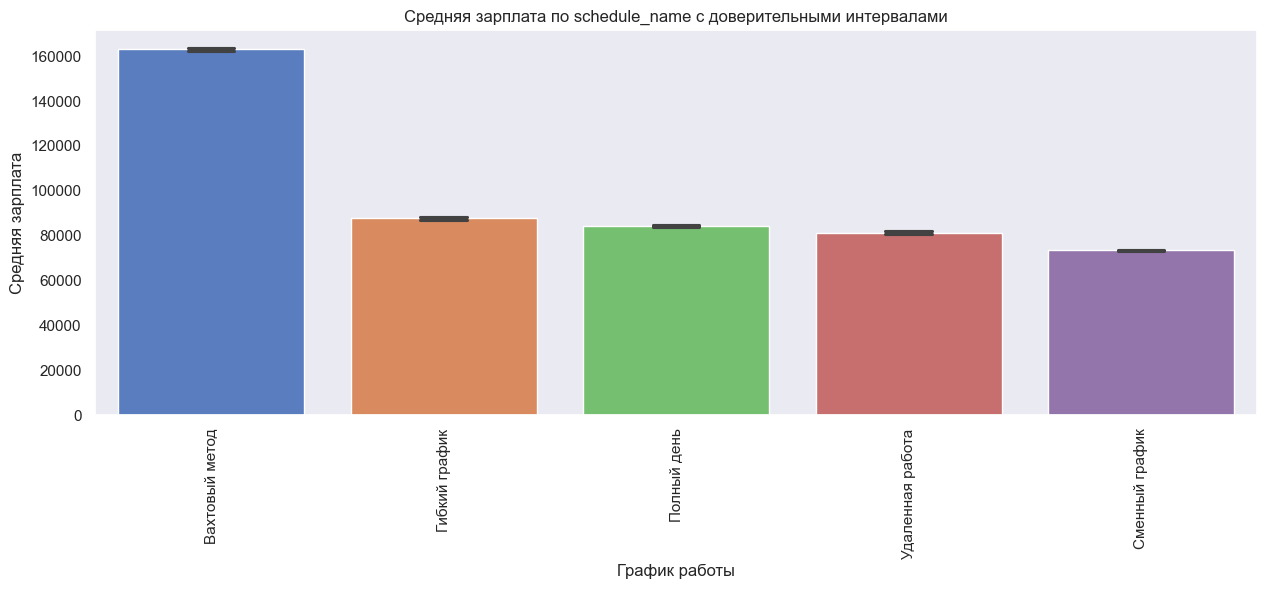

In [226]:
mean_salaries = df.groupby('schedule_name')['salary'].mean().sort_values(ascending=False)
sorted_categories = mean_salaries.index

plt.figure(figsize=(15, 5))
ax = sns.barplot(x='schedule_name', y='salary', data=df, order=sorted_categories, ci=95, palette='muted', capsize=.2)

plt.title(f'Средняя зарплата по schedule_name с доверительными интервалами')
plt.xlabel('График работы')
plt.ylabel('Средняя зарплата')
plt.xticks(rotation=90)
plt.show()

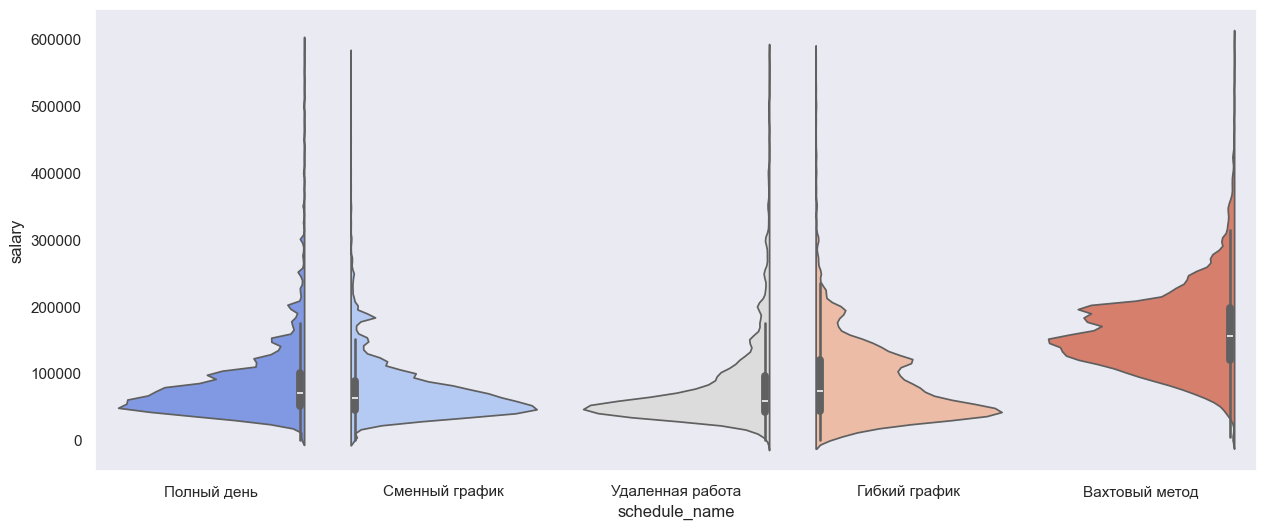

In [227]:
plt.figure(figsize = (15, 6))
sns.violinplot(
    x = filtered_df['schedule_name'],
    y = filtered_df['salary'],
    split = True,
    palette = "coolwarm"
)
plt.show()

In [228]:
filtered_df['schedule_name'].unique()

array(['Полный день', 'Сменный график', 'Удаленная работа',
       'Гибкий график', 'Вахтовый метод'], dtype=object)

In [229]:
name = 'Вахтовый метод'

print(df.loc[df['schedule_name'] == name, 'salary'].median())
print(df.loc[df['schedule_name'] == name, 'salary'].quantile(0.25))
print(df.loc[df['schedule_name'] == name, 'salary'].quantile(0.75))

155000.0
120000.0
197500.0


Был удалён столбец schedule_id, тк он полностью повторяет стоббец schedule_name - название графика рабочего дня. Пропусков и анамалий в данных нет, всего у нас 5 уникальных объектов:

1. **Полный день**. Самый частый график, который предлагает работодатель - 61,7%. При этом занимает 3 место по ЗП: медианное значение состовляет 70.000 рублей, 50% данных лежит в пределах 50к - 100к, max значение по усам достигает ~180к.
2. **Сменный график**. 17.6% от всех графиков. Последнее место по ЗП: медианное значение состовляет 62.010 рублей, 50% данных лежит в пределах 45.000 - 87.500, max значение по усам достигает ~140к.
3. **Удаленная работа**. Самый редкий график рабочего дня, который предлагает работодатель - 5.1%. Занимает 4 место по ЗП: медианное значение состовляет 58.500 рублей, 50% данных лежит в пределах 42.250 - 95.000, max значение по усам достигает ~160к.
4. **Гибкий график**. 7% от общего объёма вакансий. Занимает 2 место по ЗП: медианное значение состовляет 72.600 рублей, 50% данных лежит в пределах 43.400 - 120000, max значение по усам достигает ~240к.
5. **Вахтовый метод**. 8.6%. Очевидно 1 место по ЗП: медианное значение состовляет 155.000 рублей, 50% данных лежит в пределах 120.000 - 197.500, max значение по усам достигает ~320к.

##### Столбец accept_temporary

In [230]:
df['accept_temporary'].unique()

array([False,  True])

In [231]:
df['accept_temporary'].info()

<class 'pandas.core.series.Series'>
Index: 709568 entries, 0 to 709571
Series name: accept_temporary
Non-Null Count   Dtype
--------------   -----
709568 non-null  bool 
dtypes: bool(1)
memory usage: 6.1 MB


In [232]:
nan_accept_temporary = df['accept_temporary'].isna().sum()
print(f'Колчиество NaN объектов: {nan_accept_temporary}')

Колчиество NaN объектов: 0


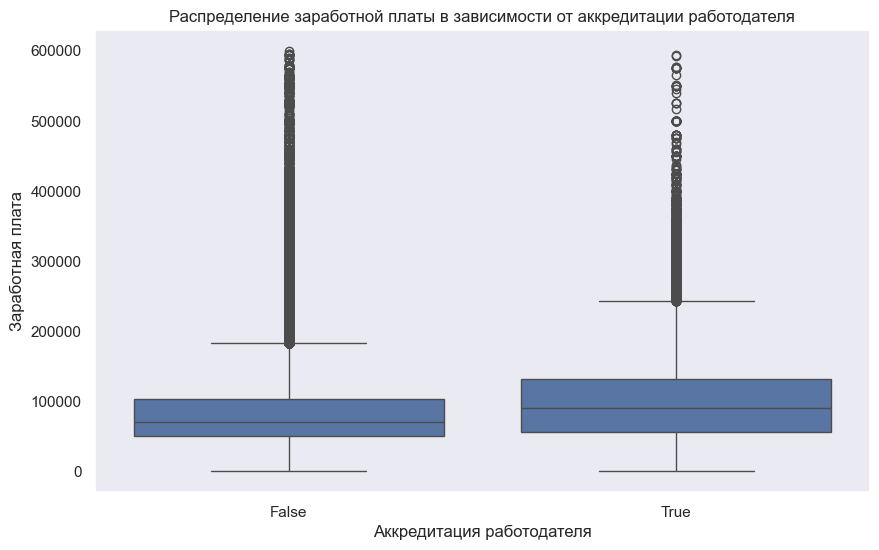

In [233]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='accept_temporary', y='salary', data=filtered_df)
plt.title('Распределение заработной платы в зависимости от аккредитации работодателя')
plt.xlabel('Аккредитация работодателя')
plt.ylabel('Заработная плата')
plt.show()

Столбец accept_temporary может означать:

- true: Соискатель готов принимать вакансии на временной основе (контрактные, краткосрочные проекты и т.д.).
- false: Соискатель заинтересован только в постоянных рабочих местах, и временные позиции его не устраивают.

При этом нет особой разницы в при разных значениях, разве что True немного превышет ЗП ожидания.

##### Столбец professional_roles_0_id и professional_roles_0_name

In [234]:
df['professional_roles_0_id'].unique()

array([ 70,  40,  48, 129, 131,  21,  55,   8,  39,  88,  85,  47,  74,
        64,   5,  94, 142,  33, 128, 130,  18,  97, 170,  24,  59, 109,
       119, 143, 146,  62, 102,  58,  35,  76, 132, 127, 104, 107,  86,
       148, 144,  99,  82,  96,  89,  45,  31, 111, 162,  57,  34,  92,
        81, 136,  10, 110,  73,  69, 113, 123, 118, 145,   9,  23,  66,
        27,  52,  67,  30,  71, 139,  28,  60,  95,  68, 115, 116, 121,
        78, 141,  32,  46,  17, 100,  61, 124,  91, 169,  84,  38,   1,
         7, 137, 133, 134,   6, 114,  19, 101,  83,  77,  72, 106, 120,
       152,  49,   3,  54, 163,  90,  20,  51,  16, 149, 135,  15, 117,
        26,  44, 125,  53, 138,  14,  63, 108,  50, 154, 159,   2, 140,
        80,  79, 174,  87, 166, 173, 105,  13, 150, 167, 153,  42, 165,
       151,  93,  36,  12, 103, 156, 158, 168,  98,  65, 160,  41, 122,
       112,   4,  56, 164,  37, 155, 161,  11, 172,  75, 171,  22,  29,
       126, 157, 147,  25,  43])

In [235]:
df['professional_roles_0_name'].unique()

array(['Менеджер по продажам, менеджер по работе с клиентами', 'Другое',
       'Инженер-конструктор, инженер-проектировщик',
       'Торговый представитель', 'Упаковщик, комплектовщик', 'Водитель',
       'Копирайтер, редактор, корректор', 'Администратор', 'Диспетчер',
       'Офис-менеджер', 'Оператор производственной линии',
       'Инженер ПТО, инженер-сметчик', 'Менеджер ресторана',
       'Медицинская сестра, медицинский брат', 'Автослесарь, автомеханик',
       'Повар, пекарь, кондитер', 'Экономист',
       'Делопроизводитель, архивариус', 'Токарь, фрезеровщик, шлифовщик',
       'Уборщица, уборщик', 'Бухгалтер',
       'Продавец-консультант, продавец-кассир',
       'Руководитель отдела маркетинга и рекламы', 'Врач',
       'Маляр, штукатур', 'Сварщик', 'Специалист по тендерам',
       'Электромонтажник', 'Юрист', 'Мастер-приемщик', 'Разнорабочий',
       'Курьер', 'Директор магазина, директор сети магазинов',
       'Менеджер/руководитель АХО', 'Учитель, преподаватель, педагог

In [236]:
del df['professional_roles_0_id']

In [237]:
nan_professional_roles = df['professional_roles_0_name'].isna().sum()
print(f'Колчиество NaN объектов: {nan_professional_roles}')

Колчиество NaN объектов: 0


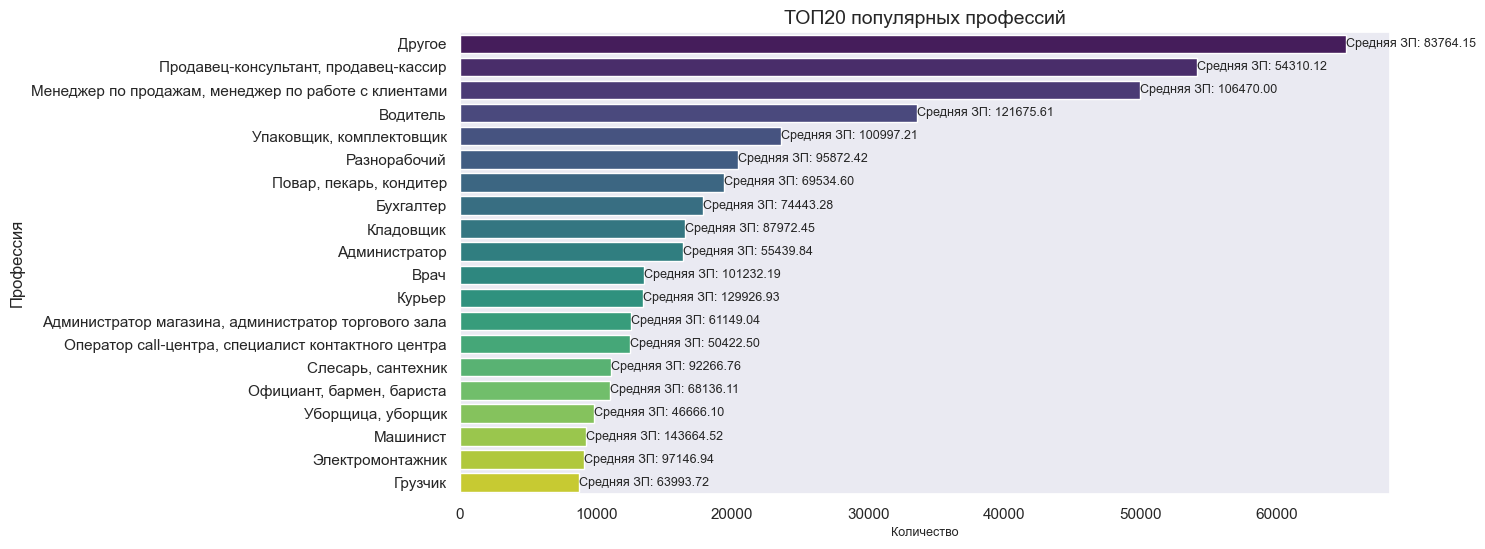

In [238]:
role_counts = df['professional_roles_0_name'].value_counts()

top_roles = role_counts.index
mean_salaries = df[df['professional_roles_0_name'].isin(top_roles[:20])].groupby('professional_roles_0_name')['salary'].mean()

role_counts = role_counts[:20]

plt.figure(figsize=(12, 6))
barplot = sns.barplot(x=role_counts.values, y=role_counts.index, palette='viridis')

for index, value in enumerate(role_counts.index):
    mean_salary = mean_salaries[value]
    barplot.text(role_counts.values[index], index, f'Средняя ЗП: {mean_salary:.2f}', va='center', ha='left', fontsize=9)

plt.title('ТОП20 популярных профессий', fontsize=14)
plt.xlabel('Количество', fontsize=9)
plt.ylabel('Профессия')
plt.show()

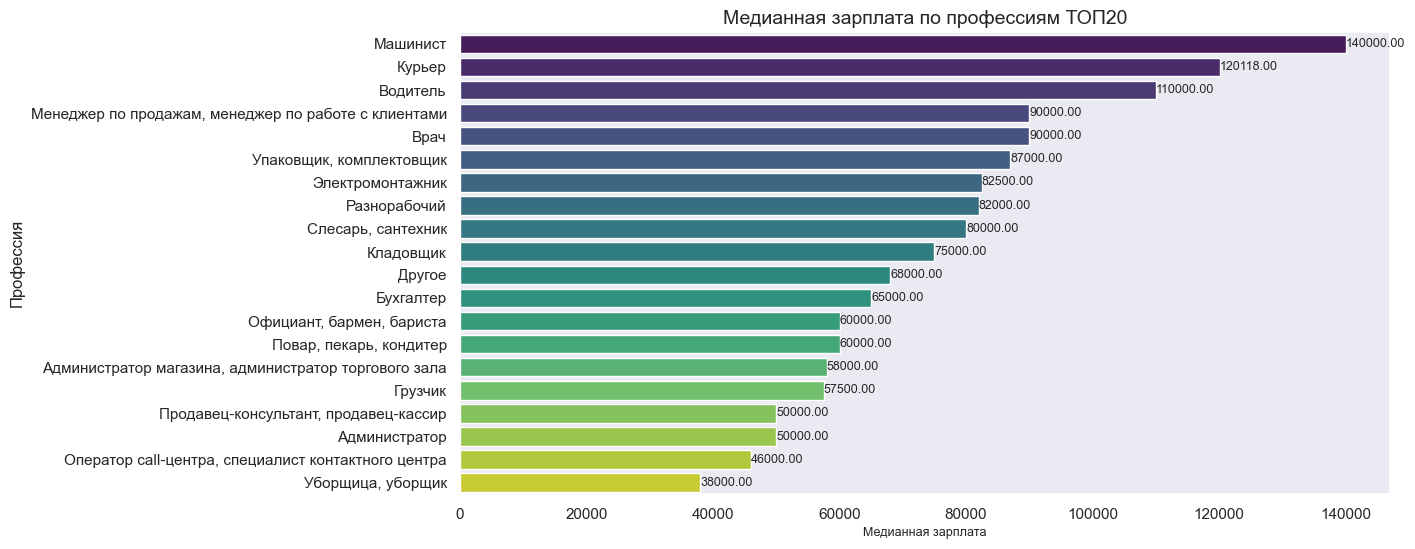

In [239]:
mean_salaries = df[df['professional_roles_0_name'].isin(top_roles[:20])].groupby('professional_roles_0_name')['salary'].median()
sorted_roles_by_salary = mean_salaries.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
barplot = sns.barplot(x=sorted_roles_by_salary.values, y=sorted_roles_by_salary.index, palette='viridis')

for index, value in enumerate(sorted_roles_by_salary.index):
    mean_salary = sorted_roles_by_salary[value]
    barplot.text(sorted_roles_by_salary.values[index], index, f'{mean_salary:.2f}', va='center', ha='left', fontsize=9)

plt.title('Медианная зарплата по профессиям ТОП20', fontsize=14)
plt.xlabel('Медианная зарплата', fontsize=9)
plt.ylabel('Профессия')
plt.show()

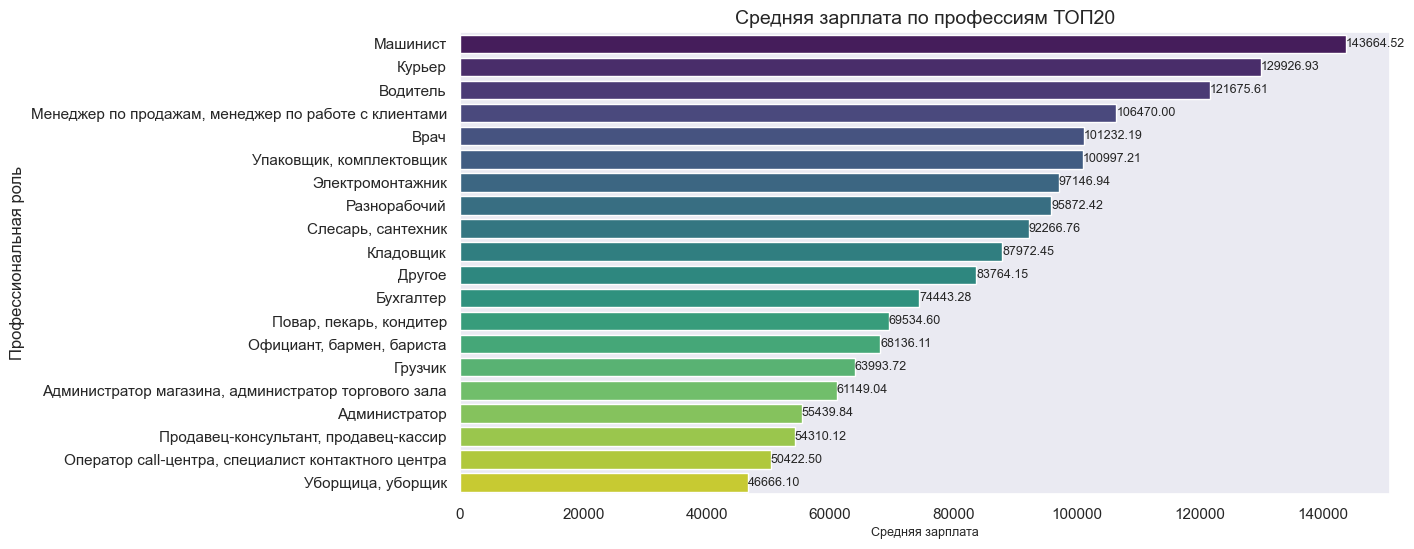

In [240]:
mean_salaries = df[df['professional_roles_0_name'].isin(top_roles[:20])].groupby('professional_roles_0_name')['salary'].mean()
sorted_roles_by_salary = mean_salaries.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
barplot = sns.barplot(x=sorted_roles_by_salary.values, y=sorted_roles_by_salary.index, palette='viridis')

for index, value in enumerate(sorted_roles_by_salary.index):
    mean_salary = sorted_roles_by_salary[value]
    barplot.text(sorted_roles_by_salary.values[index], index, f'{mean_salary:.2f}', va='center', ha='left', fontsize=9)

plt.title('Средняя зарплата по профессиям ТОП20', fontsize=14)
plt.xlabel('Средняя зарплата', fontsize=9)
plt.ylabel('Профессиональная роль')
plt.show()

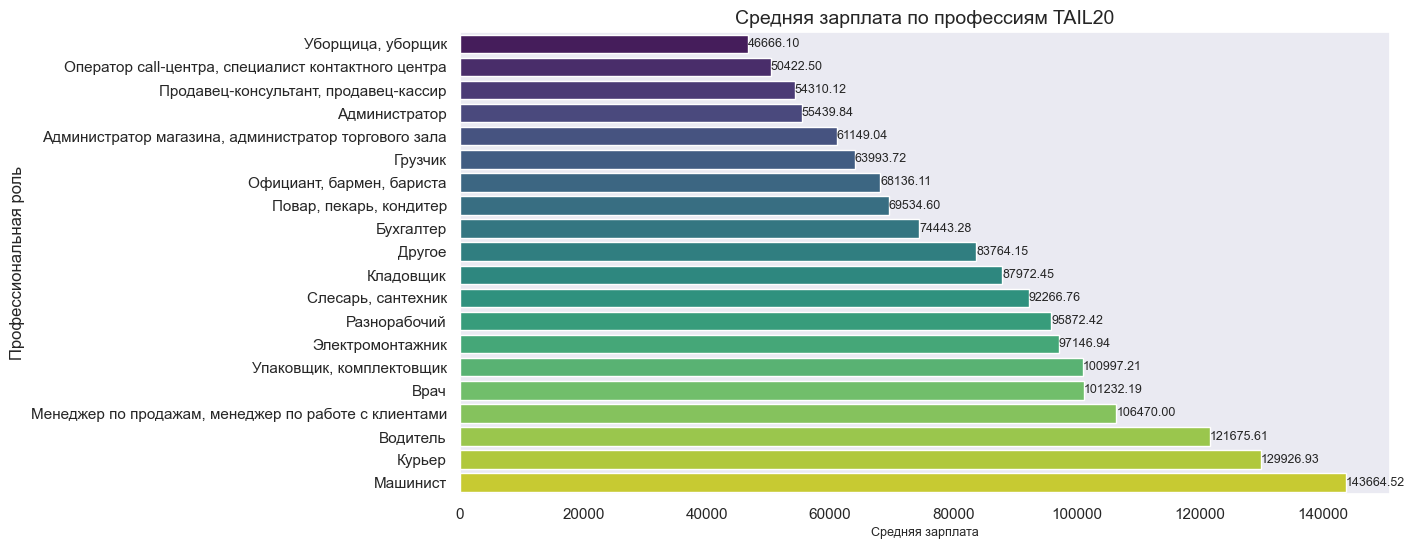

In [241]:
mean_salaries = df[df['professional_roles_0_name'].isin(top_roles[:20])].groupby('professional_roles_0_name')['salary'].mean()
sorted_roles_by_salary = mean_salaries.sort_values(ascending=True)

plt.figure(figsize=(12, 6))
barplot = sns.barplot(x=sorted_roles_by_salary.values, y=sorted_roles_by_salary.index, palette='viridis')

for index, value in enumerate(sorted_roles_by_salary.index):
    mean_salary = sorted_roles_by_salary[value]
    barplot.text(sorted_roles_by_salary.values[index], index, f'{mean_salary:.2f}', va='center', ha='left', fontsize=9)

plt.title('Средняя зарплата по профессиям TAIL20', fontsize=14)
plt.xlabel('Средняя зарплата', fontsize=9)
plt.ylabel('Профессиональная роль')
plt.show()

In [242]:
salary_groups = [group['salary'].values for _, group in df.groupby('professional_roles_0_name')]
statistic, p_value = kruskal(*salary_groups)

print(f'Статистика Краскела-Уоллиса: {statistic}')
print(f'P-value: {p_value}')

if p_value < 0.05:
    print('Существует статистически значимая зависимость между профессией и зарплатой')
else:
    print('Нет статистически значимой зависимости между профессиейи зарплатой')

Статистика Краскела-Уоллиса: 200443.09810853924
P-value: 0.0
Существует статистически значимая зависимость между профессией и зарплатой


Скоро будет вывод

##### Столбец accept_incomplete_resumes

In [243]:
df['accept_incomplete_resumes'].unique()

array([ True, False])

In [244]:
df['accept_incomplete_resumes'].info()

<class 'pandas.core.series.Series'>
Index: 709568 entries, 0 to 709571
Series name: accept_incomplete_resumes
Non-Null Count   Dtype
--------------   -----
709568 non-null  bool 
dtypes: bool(1)
memory usage: 6.1 MB


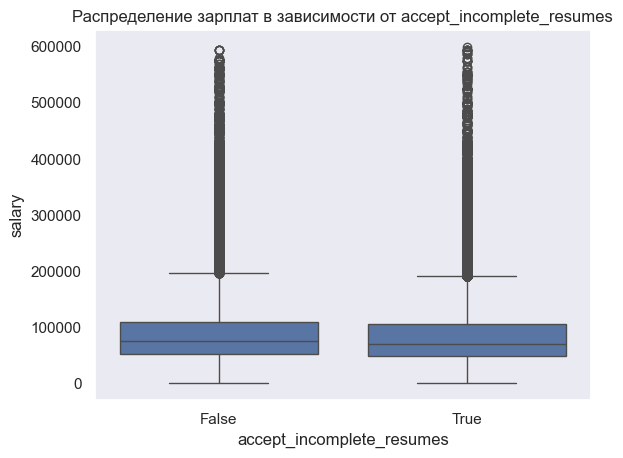

T-тест: статистика = 27.356498488293433, p-значение = 1.1014082197791337e-164
Отклоняем нулевую гипотезу: Средние значения зарплат отличаются.


In [245]:
sns.boxplot(x='accept_incomplete_resumes', y='salary', data=filtered_df)
plt.title('Распределение зарплат в зависимости от accept_incomplete_resumes')
plt.show()

group1 = df[df['accept_incomplete_resumes'] == 0]['salary']
group2 = df[df['accept_incomplete_resumes'] == 1]['salary']
t_stat, t_p_value = ttest_ind(group1, group2)
print(f"T-тест: статистика = {t_stat}, p-значение = {t_p_value}")

alpha = 0.05
if t_p_value < alpha:
    print("Отклоняем нулевую гипотезу: Средние значения зарплат отличаются.")
else:
    print("Не имеем оснований отклонить нулевую гипотезу: Средние значения зарплат равны.")

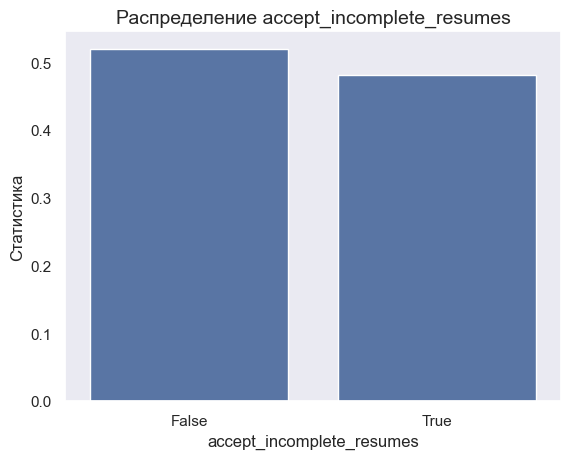

In [246]:
ax = sns.barplot(
    x=df['accept_incomplete_resumes'].value_counts(normalize=True).index,
    y=df['accept_incomplete_resumes'].value_counts(normalize=True),
)
plt.title('Распределение accept_incomplete_resumes', fontsize=14)
plt.xlabel('accept_incomplete_resumes')
plt.ylabel('Статистика')

plt.show()

##### Столбец experience_id и experience_name

In [247]:
df['experience_name'].unique()

array(['От 1 года до 3 лет', 'Нет опыта', 'От 3 до 6 лет', 'Более 6 лет'],
      dtype=object)

In [248]:
df['experience_id'].unique()

array(['between1And3', 'noExperience', 'between3And6', 'moreThan6'],
      dtype=object)

In [249]:
df[['experience_id', 'experience_name']].head(8)

,experience_id,experience_name
0,between1And3,От 1 года до 3 лет
1,noExperience,Нет опыта
2,noExperience,Нет опыта
3,between1And3,От 1 года до 3 лет
4,between3And6,От 3 до 6 лет
5,between3And6,От 3 до 6 лет
6,noExperience,Нет опыта
7,noExperience,Нет опыта


In [250]:
del df['experience_id']

In [251]:
df['experience_name'].info()

<class 'pandas.core.series.Series'>
Index: 709568 entries, 0 to 709571
Series name: experience_name
Non-Null Count   Dtype 
--------------   ----- 
709568 non-null  object
dtypes: object(1)
memory usage: 10.8+ MB


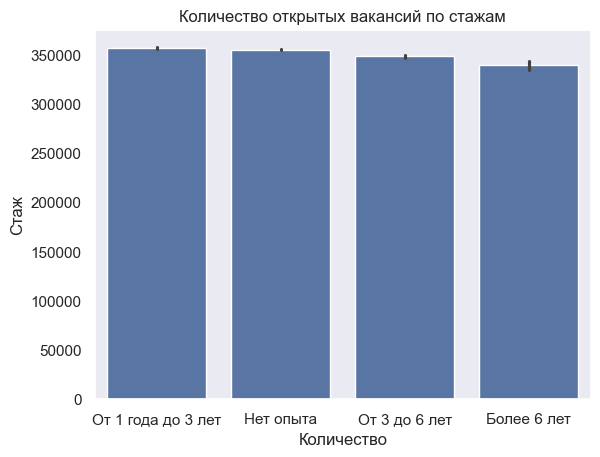

In [252]:
sns.barplot(y = df['experience_name'].index,
            x = df['experience_name'])
plt.title('Количество открытых вакансий по стажам')
plt.xlabel('Количество')
plt.ylabel('Стаж')
plt.show()

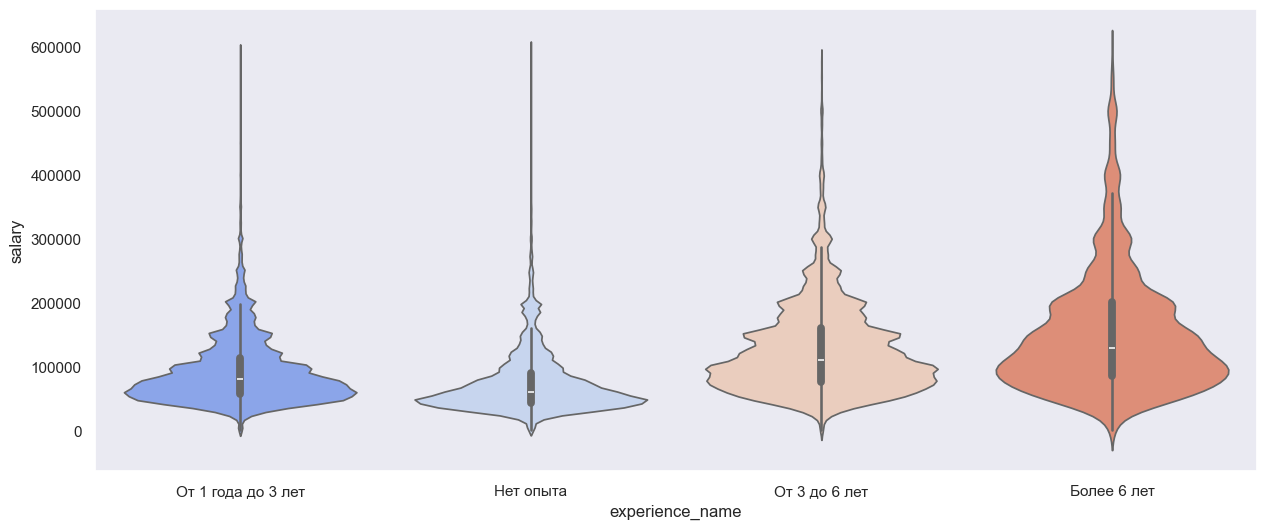

In [253]:
plt.figure(figsize = (15, 6))
sns.violinplot(
    x = filtered_df['experience_name'],
    y = filtered_df['salary'],
    split = False,
    palette = "coolwarm"
)
plt.show()

In [254]:
salary_groups = [group['salary'].values for _, group in df.groupby('experience_name')]
statistic, p_value = kruskal(*salary_groups)

print(f'Статистика Краскела-Уоллиса: {statistic}')
print(f'P-value: {p_value}')

if p_value < 0.05:
    print('Существует статистически значимая зависимость между стажем и зарплатой')
else:
    print('Нет статистически значимой зависимости между стажем и зарплатой')

Статистика Краскела-Уоллиса: 75517.90918760601
P-value: 0.0
Существует статистически значимая зависимость между стажем и зарплатой


##### Столбец employment_id и employment_name

In [255]:
df['employment_id'].unique()

array(['full', 'part', 'project', 'probation', 'volunteer'], dtype=object)

In [256]:
df['employment_name'].unique()

array(['Полная занятость', 'Частичная занятость', 'Проектная работа',
       'Стажировка', 'Волонтерство'], dtype=object)

In [257]:
df[['employment_id', 'employment_name']].sample(10)

,employment_id,employment_name
302876,full,Полная занятость
525310,part,Частичная занятость
357822,full,Полная занятость
233446,full,Полная занятость
171332,full,Полная занятость
103421,full,Полная занятость
145284,full,Полная занятость
551304,full,Полная занятость
206437,full,Полная занятость
693266,full,Полная занятость


In [258]:
del df['employment_id']

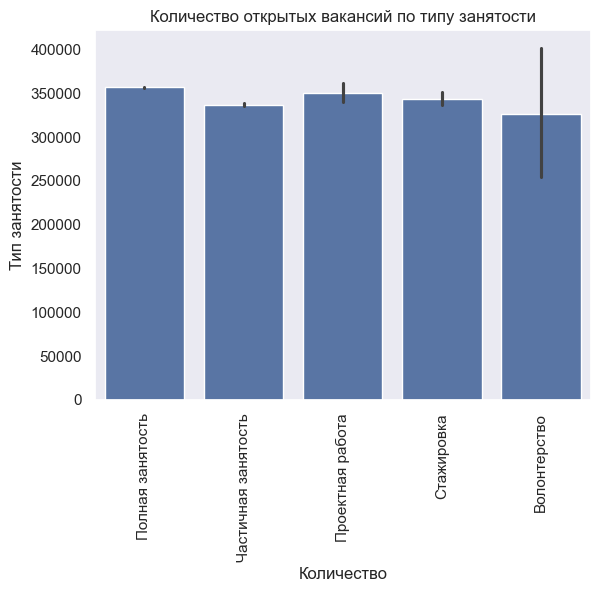

In [259]:
sns.barplot(y = df['employment_name'].index,
            x = df['employment_name'])
plt.title('Количество открытых вакансий по типу занятости')
plt.xlabel('Количество')
plt.xticks(rotation=90)
plt.ylabel('Тип занятости')
plt.show()

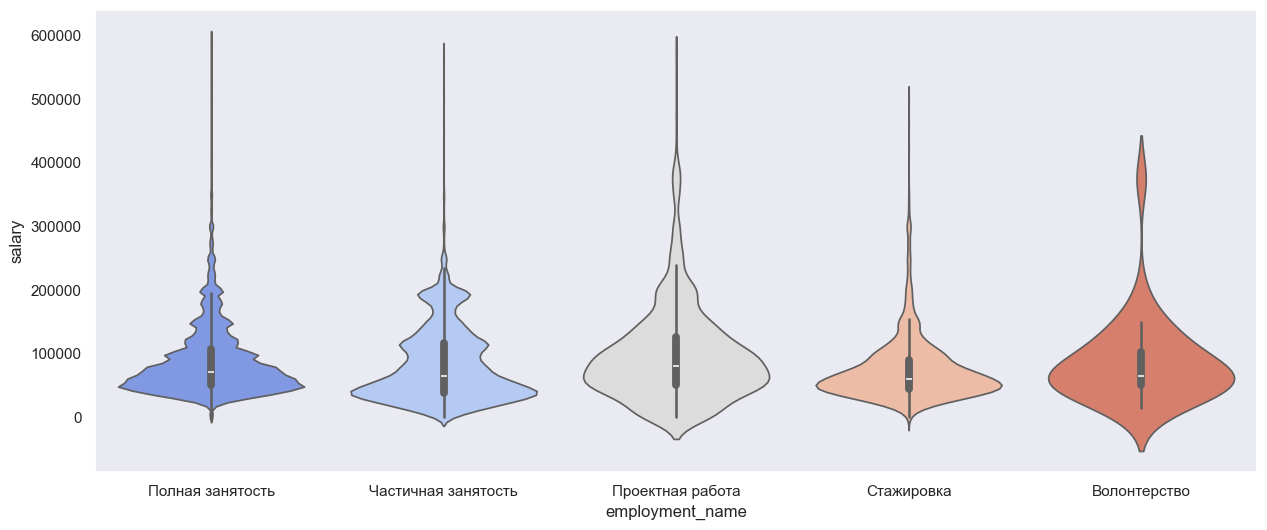

In [260]:
plt.figure(figsize = (15, 6))
sns.violinplot(
    x = filtered_df['employment_name'],
    y = filtered_df['salary'],
    split = False,
    palette = "coolwarm"
)
plt.show()

##### Столбец is_adv_vacancy

In [261]:
df['is_adv_vacancy'].unique()

array([False])

In [262]:
del df['is_adv_vacancy']

##### Столбец address_metro_stations_3_station_name и address_metro_stations_3_station_id

In [263]:
df['address_metro_stations_3_station_name'].unique()

array([nan, 'Москва-Сити', 'Ховрино', 'Тимирязевская', 'Ухтомская',
       'Электрозаводская', 'Селигерская', 'Фонвизинская', 'Речной вокзал',
       'Шоссе Энтузиастов', 'Петровско-Разумовская', 'Рязанский проспект',
       'Стахановская', 'Удельная', 'Юго-Восточная', 'Лихоборы',
       'Останкино', 'Лефортово', 'Новокосино', 'Перово',
       'Улица Дмитриевского', 'Чкаловская', 'Черкизовская',
       'Улица Горчакова', 'Чеховская', 'Красносельская', 'Театральная',
       'Площадь трёх вокзалов', 'Юго-Западная', 'Боровицкая',
       'Площадь Революции', 'Смоленская', 'Фрунзенская', 'Спортивная',
       'Киевская', 'Парк культуры', 'Первомайская', 'Сокольники',
       'Шелепиха', 'Преображенская площадь', 'Семеновская', 'Университет',
       'Серпуховская', 'Белорусская', 'Третьяковская', 'ЗИЛ', 'ЦСКА',
       'Марьино', 'Царицыно', 'Стрешнево', 'Красный Балтиец',
       'Новослободская', 'Дубровка', 'Петровский парк', 'Савёловская',
       'Сокол', 'Тверская', 'Каширская', 'Тушинская'

In [264]:
df['address_metro_stations_3_station_id'].unique()

array([    nan,   4.179,   2.558,   9.141, 135.862,  98.802,  10.597,
        10.547,   2.125,  95.524,  10.548,   7.127,   3.161,  98.764,
       135.849, 135.868,  98.762, 135.848, 135.85 ,  98.8  ,   8.189,
        97.803,   8.107,  98.676,  95.545, 135.857,  10.72 ,   1.155,
        12.168,   9.123,   1.6  ,   2.99 , 136.89 ,   1.162,   9.7  ,
         3.1  ,   3.131,   1.152,   1.135,   4.132,   5.49 ,   1.103,
         3.106,   1.134,  97.602,   1.117,   3.13 ,   1.149,   9.37 ,
       136.894,   8.91 ,  95.531,  97.6  ,  10.79 , 132.735, 132.72 ,
       132.721,   5.82 ,  95.529,  97.599, 131.699,   9.128,  95.542,
         2.133,   2.122,  97.832, 132.718,   2.96 ,  10.188, 131.704,
         3.463,   3.176,  95.523, 131.706,   3.174, 131.705, 131.703,
         4.151,   3.159,   7.146, 131.702, 135.852, 135.847,  10.113,
       135.845, 135.853, 135.864, 132.727,  96.552, 135.858,   1.143,
         9.154,   6.137,   1.64 , 132.724,   6.121,   9.163,   7.62 ,
         9.142,   5.

In [265]:
del df['address_metro_stations_3_station_id']

In [266]:
nan_address_metro_stations = df['address_metro_stations_3_station_name'].isna().sum()
print(f'Колчиество NaN объектов: {nan_address_metro_stations}')

Колчиество NaN объектов: 696802


In [267]:
df['address_metro_stations_3_station_name'].fillna('Missing', inplace=True)

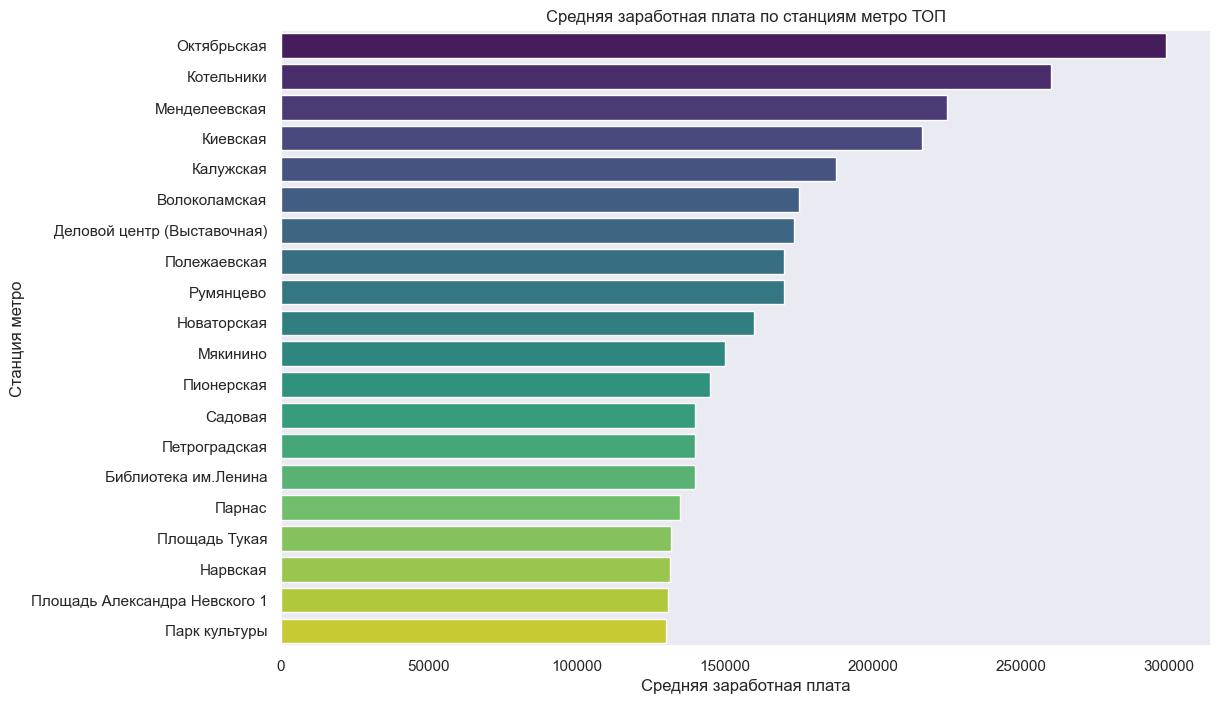

In [268]:
# Группировка данных по станциям метро и расчет средней заработной платы для каждой станции
station_salary = df.groupby('address_metro_stations_3_station_name')['salary'].median().reset_index().sort_values(by='salary', ascending=False)[:20]

# Построение barplot
plt.figure(figsize=(12, 8))
sns.barplot(data=station_salary, x='salary', y='address_metro_stations_3_station_name', palette='viridis')
plt.xlabel('Средняя заработная плата')
plt.ylabel('Станция метро')
plt.title('Средняя заработная плата по станциям метро ТОП')
plt.show()

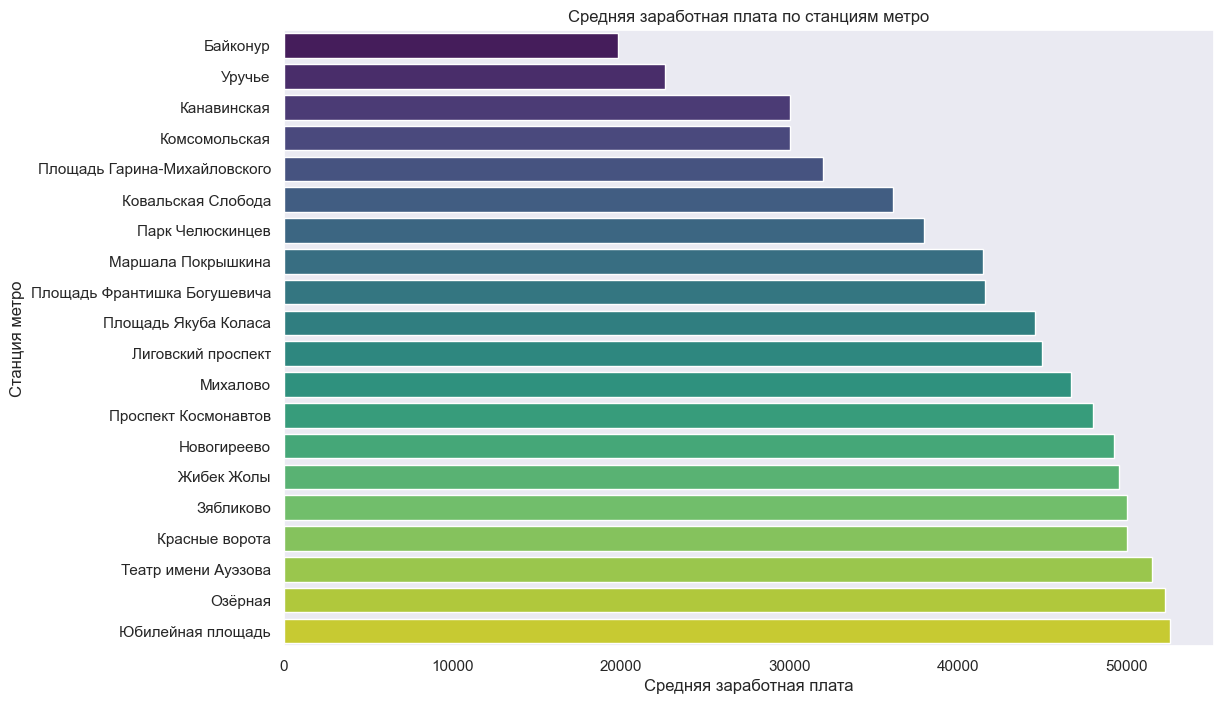

In [269]:
station_salary = df.groupby('address_metro_stations_3_station_name')['salary'].median().reset_index().sort_values(by='salary', ascending=True)[:20]

plt.figure(figsize=(12, 8))
sns.barplot(data=station_salary, x='salary', y='address_metro_stations_3_station_name', palette='viridis')
plt.xlabel('Средняя заработная плата')
plt.ylabel('Станция метро')
plt.title('Средняя заработная плата по станциям метро')
plt.show()

In [270]:
salary_groups = [group['salary'].values for _, group in df.groupby('address_metro_stations_3_station_name')]
statistic, p_value = kruskal(*salary_groups)

print(f'Статистика Краскела-Уоллиса: {statistic}')
print(f'P-value: {p_value}')

if p_value < 0.05:
    print('Существует статистически значимая зависимость между метро и зарплатой')
else:
    print('Нет статистически значимой зависимости между метро и зарплатой')

Статистика Краскела-Уоллиса: 4223.605163430795
P-value: 0.0
Существует статистически значимая зависимость между метро и зарплатой


##### Столбец address_metro_stations_3_line_name и address_metro_stations_3_line_id

In [271]:
df['address_metro_stations_3_line_name'].unique()

array([nan, 'Филевская', 'Замоскворецкая', 'Серпуховско-Тимирязевская',
       'МЦД-3', 'Некрасовская', 'Люблинско-Дмитровская', 'МЦК',
       'Таганско-Краснопресненская', 'Арбатско-Покровская', 'Калининская',
       'Большая кольцевая линия', 'Сокольническая', 'Бутовская', 'МЦД-4',
       'Кольцевая', 'МЦД-2', 'МЦД-1', 'Монорельс', 'Калужско-Рижская',
       'Солнцевская', 'Троицкая', 'Каховская', 'Правобережная',
       'Кировско-Выборгская', 'Первая', 'Автозаводская', 'Центральная',
       'Фрунзенско-Приморская', 'Московско-Петроградская', 'Ленинская',
       'Зеленолужская', 'Дзержинская', 'Невско-Василеостровская',
       'Московская', 'Север-Юг', 'Сормовская'], dtype=object)

In [272]:
df['address_metro_stations_3_line_id'].unique()

array([ nan,   4.,   2.,   9., 135.,  98.,  10.,  95.,   7.,   3.,   8.,
        97.,   1.,  12., 136.,   5., 132., 131.,  96.,   6., 133., 137.,
        11.,  17.,  14.,  54.,  64.,  63.,  49.,  18.,  50.,  15.,  52.,
       134.,  53.,  16.,  62.,  48.,  51.])

In [273]:
del df['address_metro_stations_3_line_id']

In [274]:
nan_address_metro_stations = df['address_metro_stations_3_line_name'].isna().sum()
print(f'Колчиество NaN объектов: {nan_address_metro_stations}')

Колчиество NaN объектов: 696802


In [275]:
df['address_metro_stations_3_line_name'].fillna('Missing', inplace=True)

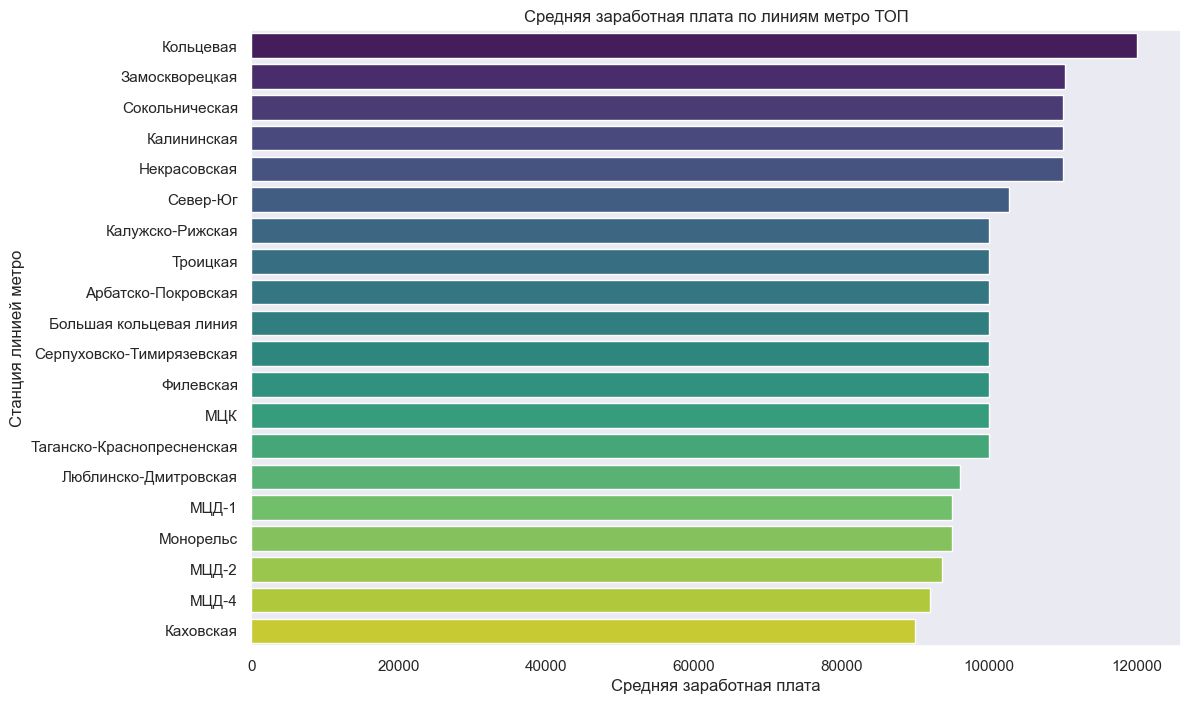

In [276]:
station_salary = df.groupby('address_metro_stations_3_line_name')['salary'].median().reset_index().sort_values(by='salary', ascending=False)[:20]

plt.figure(figsize=(12, 8))
sns.barplot(data=station_salary, x='salary', y='address_metro_stations_3_line_name', palette='viridis')
plt.xlabel('Средняя заработная плата')
plt.ylabel('Станция линией метро')
plt.title('Средняя заработная плата по линиям метро ТОП')
plt.show()

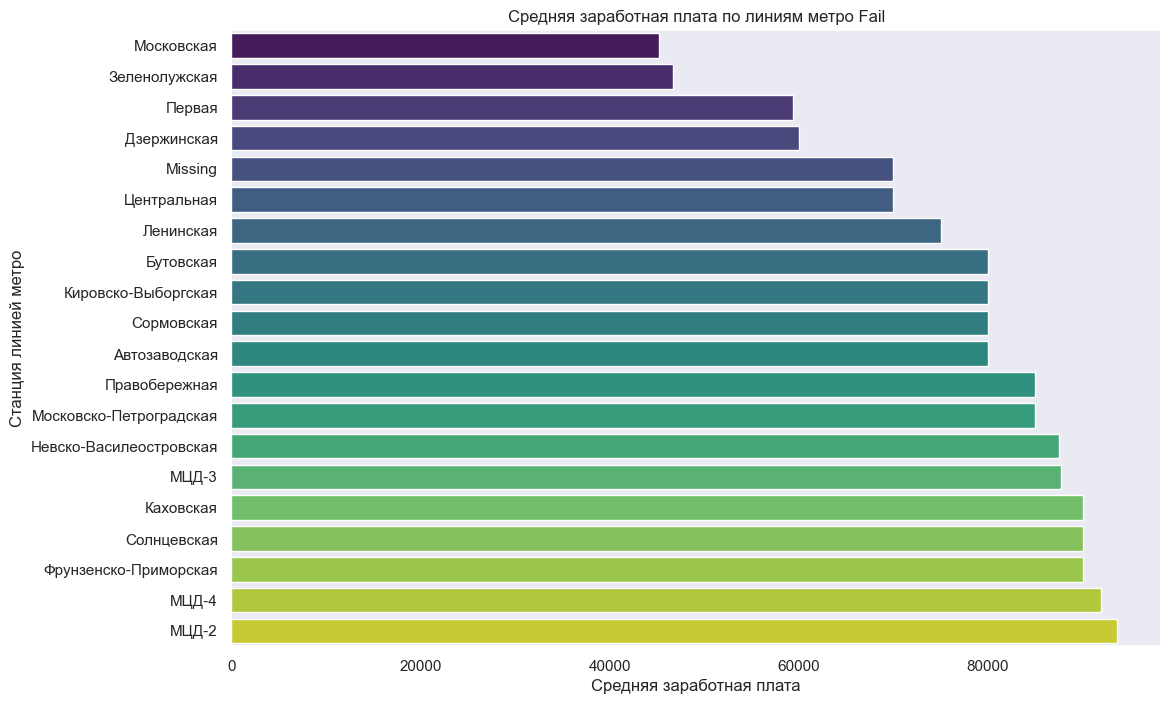

In [277]:
station_salary = df.groupby('address_metro_stations_3_line_name')['salary'].median().reset_index().sort_values(by='salary', ascending=True)[:20]

plt.figure(figsize=(12, 8))
sns.barplot(data=station_salary, x='salary', y='address_metro_stations_3_line_name', palette='viridis')
plt.xlabel('Средняя заработная плата')
plt.ylabel('Станция линией метро')
plt.title('Средняя заработная плата по линиям метро Fail')
plt.show()

In [278]:
salary_groups = [group['salary'].values for _, group in df.groupby('address_metro_stations_3_line_name')]
statistic, p_value = kruskal(*salary_groups)

print(f'Статистика Краскела-Уоллиса: {statistic}')
print(f'P-value: {p_value}')

if p_value < 0.05:
    print('Существует статистически значимая зависимость между линией метро и зарплатой')
else:
    print('Нет статистически значимой зависимости между линией метро и зарплатой')

Статистика Краскела-Уоллиса: 3716.21044066274
P-value: 0.0
Существует статистически значимая зависимость между линией метро и зарплатой


##### Столбец address_metro_stations_3_lat и address_metro_stations_3_lng

In [279]:
df['address_metro_stations_3_lng'].nunique()

350

In [280]:
df['address_metro_stations_3_lat'].nunique()

346

In [281]:
df[['address_metro_stations_3_lng', 'address_metro_stations_3_lat', 'salary']].corr()['salary']

address_metro_stations_3_lng   -0.064580
address_metro_stations_3_lat    0.009351
salary                          1.000000
Name: salary, dtype: float64

In [282]:
data = df[['address_metro_stations_3_lat', 'address_metro_stations_3_lng', 'salary']].copy()
city_center = (55.7558, 37.6173)
data['distance_to_center'] = df.apply(lambda row: distance((row['address_metro_stations_3_lat'], row['address_metro_stations_3_lng']), city_center).km, axis=1)

ValueError: Point coordinates must be finite. (nan, nan, 0.0) has been passed as coordinates.

In [ ]:
plt.figure(figsize=(10, 8))

hb = plt.hexbin(df['address_metro_stations_3_lng'], df['address_metro_stations_3_lat'], C=df['salary'], gridsize=200, cmap='coolwarm', reduce_C_function=np.mean)
cb = plt.colorbar(hb, label='Средняя зарплата')

plt.title('Тепловая карта заработной платы')
plt.xlabel('Долгота (lng)')
plt.ylabel('Широта (lat)')

plt.show()

In [138]:
nan_address_metro_stations_lat = df['address_metro_stations_3_lat'].isna().sum()
nan_address_metro_stations_lng = df['address_metro_stations_3_lng'].isna().sum()
print(f'Колчиество NaN объектов: {nan_address_metro_stations_lat}')
print(f'Колчиество NaN объектов: {nan_address_metro_stations_lng}')

Колчиество NaN объектов: 0
Колчиество NaN объектов: 0


In [137]:
df['address_metro_stations_3_lat'].fillna(-999, inplace=True)
df['address_metro_stations_3_lng'].fillna(-999, inplace=True)

##### Столбец working_time_intervals_0_id и working_time_intervals_0_name

In [144]:
df['working_time_intervals_0_id'].unique()

array([nan, 'from_four_to_six_hours_in_a_day'], dtype=object)

In [148]:
df['working_time_intervals_0_name'].unique()

array([nan, 'Можно сменами по 4-6 часов в день'], dtype=object)

In [147]:
df['working_time_intervals_0_name'] = df['working_time_intervals_0_name'].replace('Можно сменами по\xa04-6\xa0часов в\xa0день', 'Можно сменами по 4-6 часов в день')

In [150]:
del df['working_time_intervals_0_id']

In [146]:
nan_working_time_intervals = df['working_time_intervals_0_name'].isna().sum()
print(f'Колчиество NaN объектов: {nan_working_time_intervals}')

Колчиество NaN объектов: 653043


In [152]:
df['working_time_intervals_0_name'].fillna('Unknown', inplace=True)

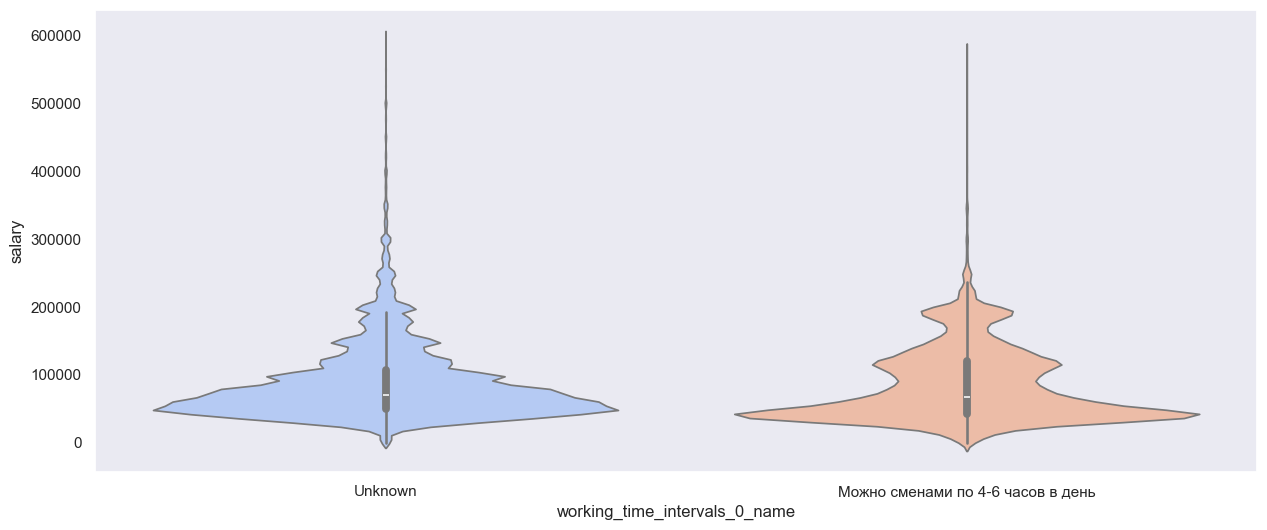

In [155]:
plt.figure(figsize = (15, 6))
sns.violinplot(
    x = df[df['salary'] < percentile_99]['working_time_intervals_0_name'],
    y = df[df['salary'] < percentile_99]['salary'],
    split = False,
    palette = "coolwarm"
)
plt.show()

In [168]:
group1 = df[df['working_time_intervals_0_name'] == 'Unknown']['salary']
group2 = df[df['working_time_intervals_0_name'] == 'Можно сменами по 4-6 часов в день']['salary']
t_stat, t_p_value = ttest_ind(group1, group2)
print(f"T-тест: статистика = {t_stat}, p-значение = {t_p_value}")

alpha = 0.05
if t_p_value < alpha:
    print("Отклоняем нулевую гипотезу: Средние значения зарплат отличаются.")
else:
    print("Не имеем оснований отклонить нулевую гипотезу: Средние значения зарплат равны.")

T-тест: статистика = 9.211563063560119, p-значение = 3.222455295762907e-20
Отклоняем нулевую гипотезу: Средние значения зарплат отличаются.


##### Столбец working_time_modes_0_id и working_time_modes_0_name

In [157]:
df['working_time_modes_0_id'].unique()

array([nan, 'start_after_sixteen'], dtype=object)

In [158]:
df['working_time_modes_0_name'].unique()

array([nan, 'С\xa0началом дня после 16:00'], dtype=object)

In [159]:
df['working_time_modes_0_name'] = df['working_time_modes_0_name'].replace('С\xa0началом дня после 16:00', 'С началом дня после 16:00')

In [160]:
del df['working_time_modes_0_id']

In [161]:
nan_working_time_modes = df['working_time_modes_0_name'].isna().sum()
print(f'Колчиество NaN объектов: {nan_working_time_modes}')

Колчиество NaN объектов: 663439


In [162]:
df['working_time_modes_0_name'].fillna('Unknown', inplace=True)

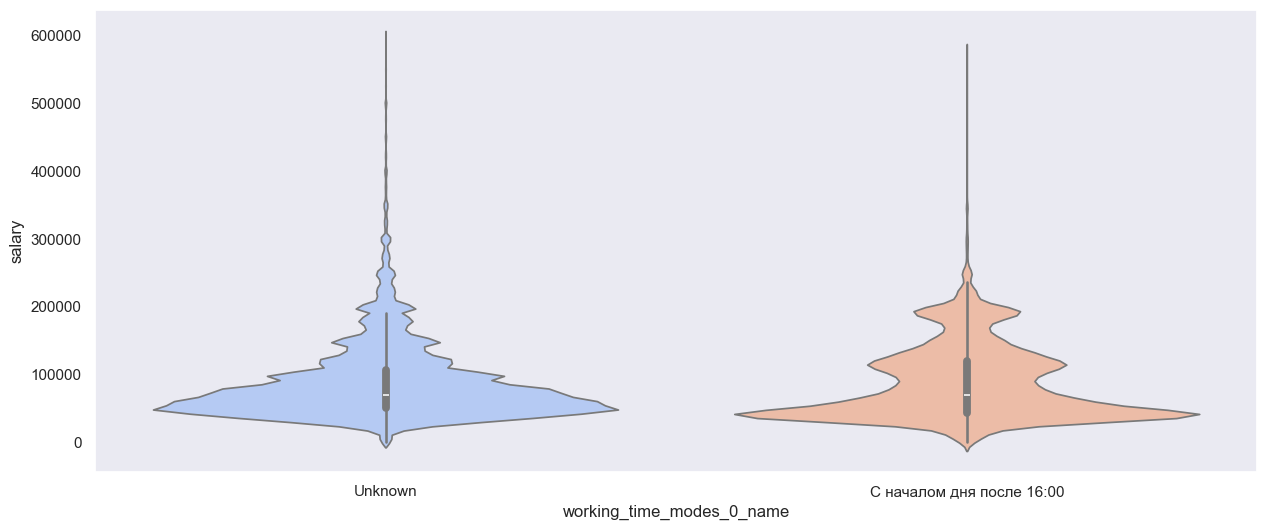

In [164]:
plt.figure(figsize = (15, 6))
sns.violinplot(
    x = df[df['salary'] < percentile_99]['working_time_modes_0_name'],
    y = df[df['salary'] < percentile_99]['salary'],
    split = False,
    palette = "coolwarm"
)
plt.show()

In [167]:
group1 = df[df['working_time_modes_0_name'] == 'Unknown']['salary']
group2 = df[df['working_time_modes_0_name'] == 'С началом дня после 16:00']['salary']
t_stat, t_p_value = ttest_ind(group1, group2)
print(f"T-тест: статистика = {t_stat}, p-значение = {t_p_value}")

alpha = 0.05
if t_p_value < alpha:
    print("Отклоняем нулевую гипотезу: Средние значения зарплат отличаются.")
else:
    print("Не имеем оснований отклонить нулевую гипотезу: Средние значения зарплат равны.")

T-тест: статистика = 1.5494603875181079, p-значение = 0.12127153289776893
Не имеем оснований отклонить нулевую гипотезу: Средние значения зарплат равны.


##### Столбец working_days_0_id и working_days_0_name

In [169]:
df['working_days_0_id'].unique()

array([nan, 'only_saturday_and_sunday'], dtype=object)

In [170]:
df['working_days_0_name'].unique()

array([nan, 'По\xa0субботам и\xa0воскресеньям'], dtype=object)

In [171]:
df['working_days_0_name'] = df['working_days_0_name'].replace('По\xa0субботам и\xa0воскресеньям', 'По субботам и воскресеньям')

In [173]:
del df['working_days_0_id']

In [175]:
nan_working_days = df['working_days_0_name'].isna().sum()
print(f'Колчиество NaN объектов: {nan_working_days}')

Колчиество NaN объектов: 678819


In [176]:
df['working_days_0_name'].fillna('Unknown', inplace=True)

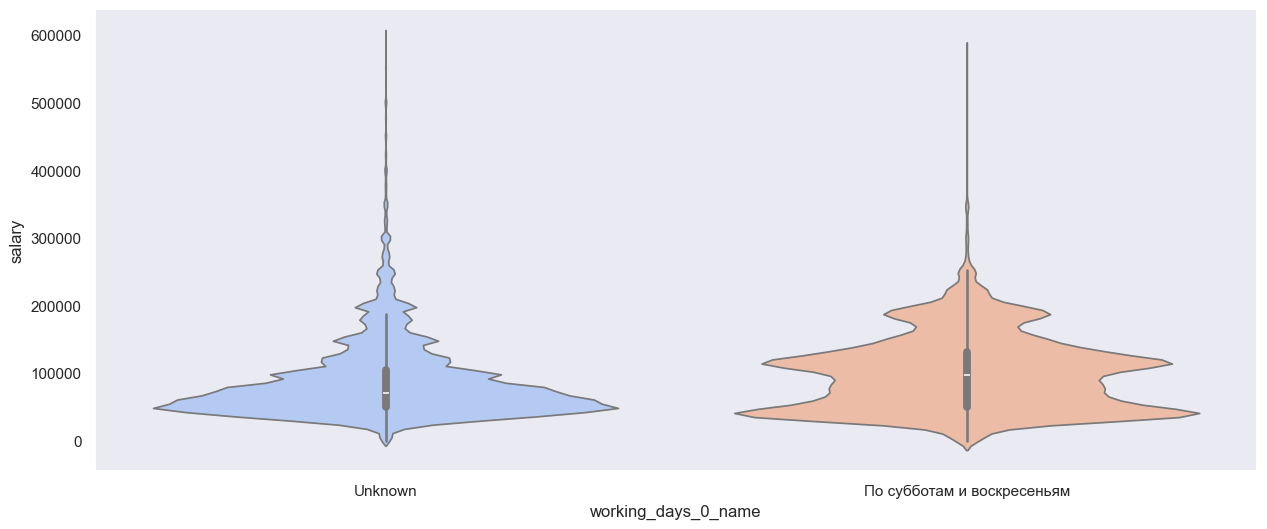

In [177]:
plt.figure(figsize = (15, 6))
sns.violinplot(
    x = df[df['salary'] < percentile_99]['working_days_0_name'],
    y = df[df['salary'] < percentile_99]['salary'],
    split = False,
    palette = "coolwarm"
)
plt.show()

In [178]:
group1 = df[df['working_days_0_name'] == 'Unknown']['salary']
group2 = df[df['working_days_0_name'] == 'По субботам и воскресеньям']['salary']
t_stat, t_p_value = ttest_ind(group1, group2)
print(f"T-тест: статистика = {t_stat}, p-значение = {t_p_value}")

alpha = 0.05
if t_p_value < alpha:
    print("Отклоняем нулевую гипотезу: Средние значения зарплат отличаются.")
else:
    print("Не имеем оснований отклонить нулевую гипотезу: Средние значения зарплат равны.")

T-тест: статистика = -19.523388484878527, p-значение = 7.314172349455211e-85
Отклоняем нулевую гипотезу: Средние значения зарплат отличаются.


##### Столбец branding_type

In [179]:
df['branding_type'].unique()

array([nan, 'MAKEUP', 'CONSTRUCTOR'], dtype=object)

In [182]:
nan_branding_type = df['branding_type'].isna().sum()
print(f'Колчиество NaN объектов: {nan_branding_type}')

Колчиество NaN объектов: 530062


In [184]:
df['branding_type'].fillna('Unknown', inplace=True)

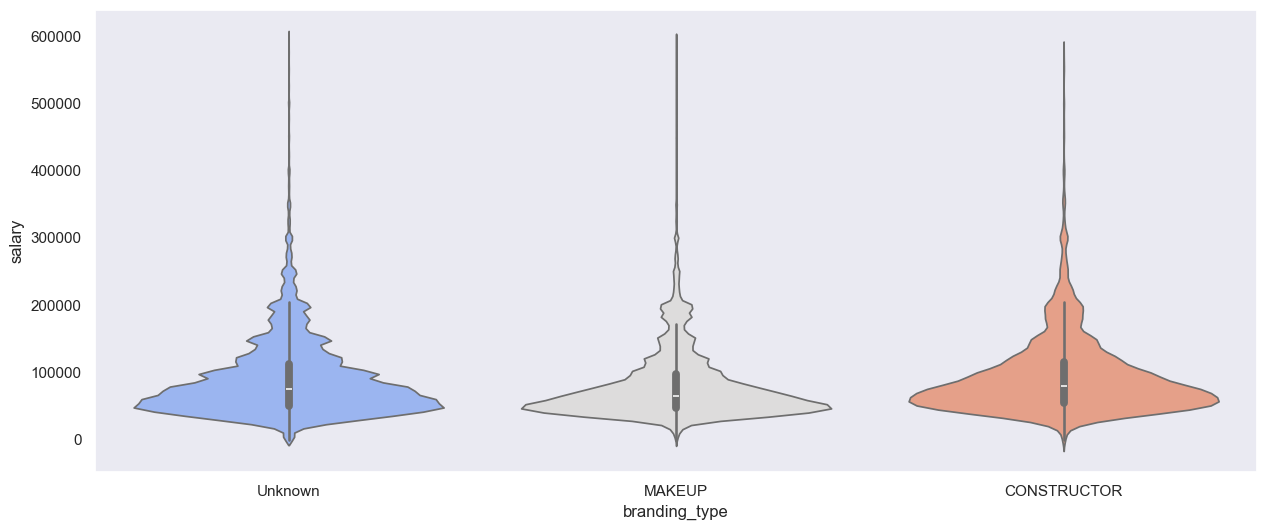

In [185]:
plt.figure(figsize = (15, 6))
sns.violinplot(
    x = df[df['salary'] < percentile_99]['branding_type'],
    y = df[df['salary'] < percentile_99]['salary'],
    split = False,
    palette = "coolwarm"
)
plt.show()

In [190]:
salary_groups = [group['salary'].values for _, group in filtered_df.groupby('branding_type')]
statistic, p_value = kruskal(*salary_groups)

print(f'Статистика Краскела-Уоллиса: {statistic}')
print(f'P-value: {p_value}')

if p_value < 0.05:
    print('Существует статистически значимая зависимость между  и зарплатой')
else:
    print('Нет статистически значимой зависимости между  и зарплатой')

Статистика Краскела-Уоллиса: 1298.950478741943
P-value: 1.91116186579962e-284
Существует статистически значимая зависимость между  и зарплатой


##### Столбец branding_tariff

In [181]:
df['branding_tariff'].unique()

array([nan, 'BASIC'], dtype=object)

In [187]:
nan_branding_tariff = df['branding_tariff'].isna().sum()
print(f'Колчиество NaN объектов: {nan_branding_tariff}')

Колчиество NaN объектов: 695718


In [188]:
df['branding_tariff'].fillna('Unknown', inplace=True)

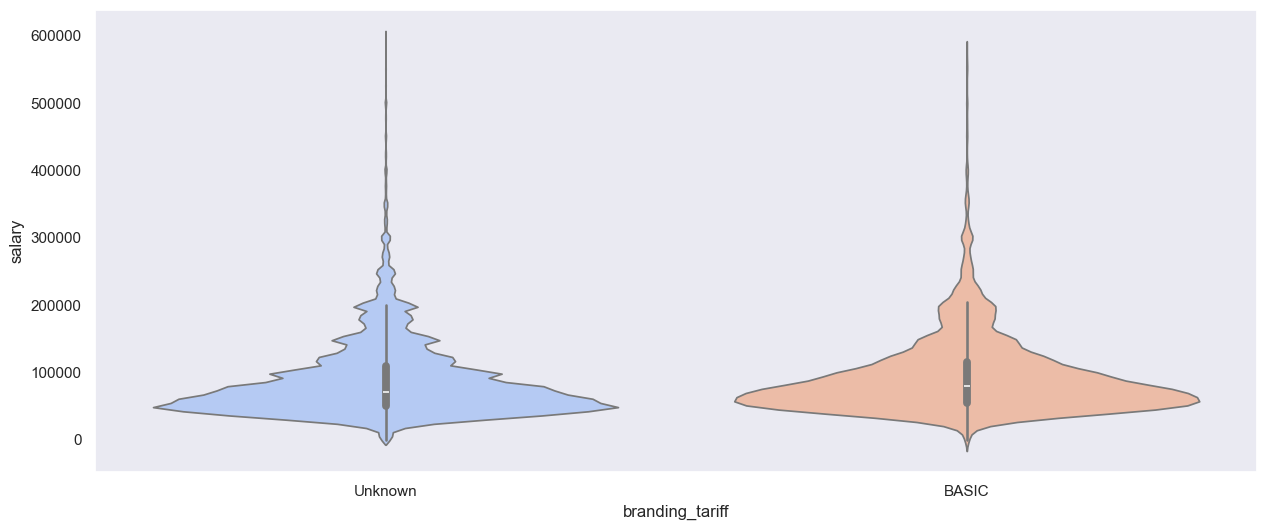

In [189]:
plt.figure(figsize = (15, 6))
sns.violinplot(
    x = df[df['salary'] < percentile_99]['branding_tariff'],
    y = df[df['salary'] < percentile_99]['salary'],
    split = False,
    palette = "coolwarm"
)
plt.show()

In [191]:
group1 = df[df['branding_tariff'] == 'Unknown']['salary']
group2 = df[df['branding_tariff'] == 'BASIC']['salary']
t_stat, t_p_value = ttest_ind(group1, group2)
print(f"T-тест: статистика = {t_stat}, p-значение = {t_p_value}")

alpha = 0.05
if t_p_value < alpha:
    print("Отклоняем нулевую гипотезу: Средние значения зарплат отличаются.")
else:
    print("Не имеем оснований отклонить нулевую гипотезу: Средние значения зарплат равны.")

T-тест: статистика = -7.792323711028853, p-значение = 6.587623757993402e-15
Отклоняем нулевую гипотезу: Средние значения зарплат отличаются.


##### Столбец department_id и department_name

In [192]:
df['department_id'].unique()

array([nan, '1942330-1942330-magaz', '1049556-1049556-work',
       'fixprice-196621-market', 'cherkizovo-1346-ofis', 'LCR-3344-mned',
       '1030733-1030733-ver', '10413982-10413982-emin',
       'pochta-4352-depart', 'pochta-4352-office', '99966-99966-ptz',
       '816144-816144-darkst', '62136-62136-invest',
       '62136-62136-comfort', '866666-866666-market', 'rns-5923-RKMo',
       '80-80-expert', '10413982-10413982-cfit', '80-80-bank',
       '4606-4606-shops', '1030733-1030733-magazin', 'tsum-52389-tsum',
       'okey-1276-market', '522-522-omk', '54979-54979-shop',
       'azbvk-2120-super', 'ozonru-2180-express', 'azbvk-2120-mini',
       '6591-6591-biz', 'azbvk-2120-gastr', 'vtb-4181-rbiz',
       'mari-231418-roznset', 'LCR-3344-gruz', '23186-23186-meat',
       '53797-53797-efkoanlt', '62136-62136-saleprod',
       '53797-53797-efkoadmn', '3529-3529-prof', 'CG-37318-tvoidom',
       '12550-12550-pick', '80-80-call', '4880-4880-office',
       '4880-4880-dm', '3414-3414-mv

In [193]:
df['department_name'].unique()

array([nan, 'Пятёрочка. Команда магазинов',
       'Почта Банк. Работа с клиентами', 'Fix Price. Магазины',
       '«Группа Черкизово», Центральный офис',
       'ЛСР. Недвижимость - Москва', 'Верный',
       'Restaurants by Emin Agalarov',
       '«Почта России», Отделение почтовой связи', '«Почта России», Офис',
       '«Spar»,Торговый зал', 'ВкусВилл. Даркстор',
       'Sminex Финансы, Юриспруденция и Инвестиции',
       'Sminex Служба комфорта', 'BetBoom.Маркетинг',
       'Ренессанс Банк, Москва', 'Альфа-Банк. Центральный офис',
       'Crocus Fitness', 'Альфа-Банк', 'Familia. Магазины',
       'Верный.Магазин', 'ЦУМ', ' О’КЕЙ Магазины', 'ОМК',
       'АШАН Ритейл Россия, Работа в магазине',
       'Супермаркеты «Азбука вкуса» ', 'Ozon fresh',
       'Минимаркеты «Азбука daily» ',
       'ПАО «Промсвязьбанк», Бизнес и инфраструктура',
       ' «Азбука вкуса». Ресторанная служба и приготовление на местах',
       'ПАО ВТБ, Розничный бизнес',
       'Компания «Мария». Вакансии в сту

In [194]:
del df['department_id']

In [195]:
nan_department_name = df['department_name'].isna().sum()
print(f'Колчиество NaN объектов: {nan_department_name}')

Колчиество NaN объектов: 634876


In [196]:
df['department_name'].fillna('Unknown', inplace=True)

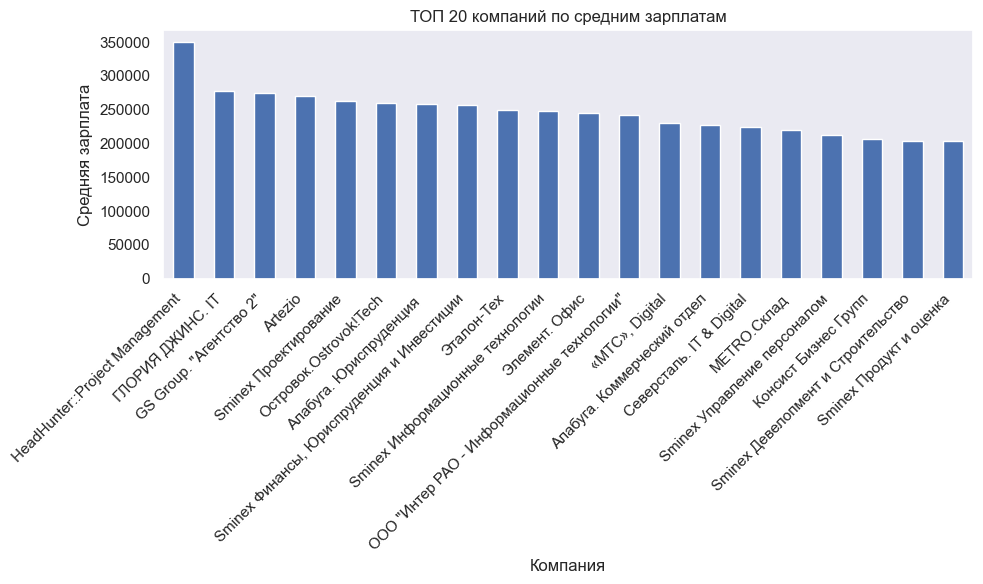

In [198]:
average_salary = df.groupby('department_name')['salary'].mean()
top_20_companies = average_salary.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
top_20_companies.plot(kind='bar')
plt.title('ТОП 20 компаний по средним зарплатам')
plt.xlabel('Компания')
plt.ylabel('Средняя зарплата')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

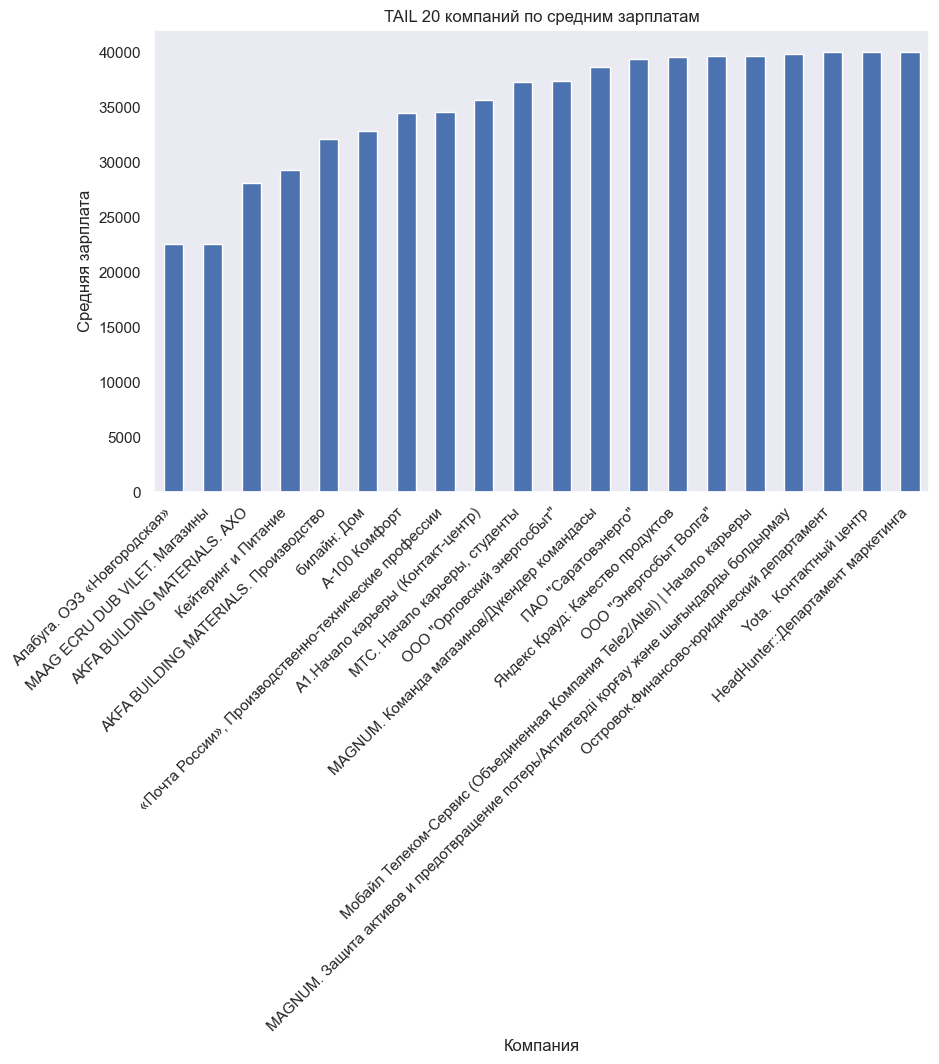

In [199]:
tail_20_companies = average_salary.sort_values(ascending=True).head(20)

plt.figure(figsize=(10, 6))
tail_20_companies.plot(kind='bar')
plt.title('TAIL 20 компаний по средним зарплатам')
plt.xlabel('Компания')
plt.ylabel('Средняя зарплата')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

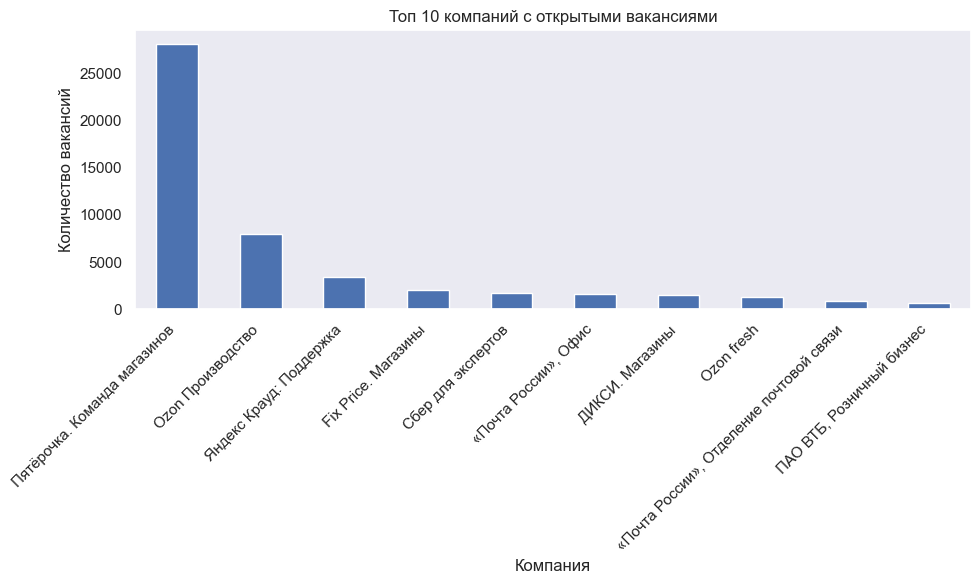

In [203]:
vacancies_count = df.loc[df['department_name'] != 'Unknown', 'department_name'].value_counts()
top_10_vacancies = vacancies_count.head(10)

plt.figure(figsize=(10, 6))
top_10_vacancies.plot(kind='bar')
plt.title('Топ 10 компаний с открытыми вакансиями')
plt.xlabel('Компания')
plt.ylabel('Количество вакансий')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [205]:
salary_groups = [group['salary'].values for _, group in df.loc[df['department_name'] != 'Unknown'].groupby('department_name')]
statistic, p_value = kruskal(*salary_groups)

print(f'Статистика Краскела-Уоллиса: {statistic}')
print(f'P-value: {p_value}')

if p_value < 0.05:
    print('Существует статистически значимая зависимость между компанией и зарплатой в ней')
else:
    print('Нет статистически значимой зависимости между компанией и зарплатой в ней')

Статистика Краскела-Уоллиса: 39034.597886333984
P-value: 0.0
Существует статистически значимая зависимость между компанией и зарплатой в ней


##### Столбец insider_interview_id и insider_interview_url

In [206]:
df['insider_interview_id'].unique()

array([   nan, 33161., 31486., 32631., 31426., 33200., 27906., 27120.,
       33004., 32978., 32903., 32938., 33155., 32346., 31084., 32937.,
       31891., 33096., 27832., 33098., 33047., 32857., 21442., 32890.,
       32984., 32278., 32905., 33003., 30809., 24989., 31262., 32032.,
       21446., 18140., 32866., 21444., 30757., 32891., 33045., 32665.,
       33046.])

In [207]:
df['insider_interview_url'].unique()

array([nan, 'https://hh.ru/interview/33161?employerId=10610846',
       'https://hh.ru/interview/31486?employerId=80',
       'https://hh.ru/interview/32631?employerId=80',
       'https://hh.ru/interview/31426?employerId=522',
       'https://hh.ru/interview/33200?employerId=54979',
       'https://hh.ru/interview/27906?employerId=2120',
       'https://hh.ru/interview/27120?employerId=27708',
       'https://hh.ru/interview/33004?employerId=4880',
       'https://hh.ru/interview/32978?employerId=78638',
       'https://hh.ru/interview/32903?employerId=895945',
       'https://hh.ru/interview/32938?employerId=2343',
       'https://hh.ru/interview/33155?employerId=697715',
       'https://hh.ru/interview/32346?employerId=77364',
       'https://hh.ru/interview/31084?employerId=4233',
       'https://hh.ru/interview/32937?employerId=1833',
       'https://hh.ru/interview/31891?employerId=1942330',
       'https://hh.ru/interview/33096?employerId=11036',
       'https://hh.ru/interview/

In [208]:
del df['insider_interview_id']
del df['insider_interview_url']

In [31]:
dima_columns = df.columns[92:]
dima_columns

Index(['brand_snippet_logo', 'brand_snippet_logo_xs',
       'brand_snippet_logo_scalable_default_width',
       'brand_snippet_logo_scalable_default_height',
       'brand_snippet_logo_scalable_default_url',
       'brand_snippet_logo_scalable_xs_width',
       'brand_snippet_logo_scalable_xs_height',
       'brand_snippet_logo_scalable_xs_url', 'brand_snippet_picture',
       'brand_snippet_picture_xs',
       'brand_snippet_picture_scalable_default_width',
       'brand_snippet_picture_scalable_default_height',
       'brand_snippet_picture_scalable_default_url',
       'brand_snippet_picture_scalable_xs_width',
       'brand_snippet_picture_scalable_xs_height',
       'brand_snippet_picture_scalable_xs_url',
       'brand_snippet_background_color',
       'brand_snippet_background_gradient_angle',
       'brand_snippet_background_gradient_color_list_0_color',
       'brand_snippet_background_gradient_color_list_0_position',
       'brand_snippet_background_gradient_color_list_1_col

##### Столбцы brand_snippet

In [162]:
brand_snippet_cols = [col for col in df.columns if 'brand_snippet' in col]
nan_counts = df[brand_snippet_cols].isna().sum()
not_nan_counts = df[brand_snippet_cols].notna().sum()
print("Number of NaN values ​​by columns:")
print(nan_counts)
print("\nNumber of non-NaN values ​​by columns:")
print(not_nan_counts)

Number of NaN values ​​by columns:
brand_snippet_logo                                         0
brand_snippet_picture                                      0
brand_snippet_background_color                             0
brand_snippet_background_gradient_angle                    0
brand_snippet_background_gradient_color_list_0_color       0
brand_snippet_background_gradient_color_list_0_position    0
brand_snippet_background_gradient_color_list_1_color       0
brand_snippet_background_gradient_color_list_1_position    0
dtype: int64

Number of non-NaN values ​​by columns:
brand_snippet_logo                                         709568
brand_snippet_picture                                      709568
brand_snippet_background_color                             709568
brand_snippet_background_gradient_angle                    709568
brand_snippet_background_gradient_color_list_0_color       709568
brand_snippet_background_gradient_color_list_0_position    709568
brand_snippet_background_gra

In [152]:
df[brand_snippet_cols] = df[brand_snippet_cols].fillna('Unknown', inplace=False)

In [154]:
brand_snippet_cols = [col for col in df.columns if 'brand_snippet' in col]
for column in brand_snippet_cols:

    salary_groups = [ group['salary'].values for _, group in df.loc[df[column] != 'Unknown'].groupby(column)]

# If each group contains at least one value
    if len(salary_groups) > 1 and all(len(group) > 0 for group in salary_groups):
    # Performing Kruskal-Wallis
        statistic, p_value = kruskal(*salary_groups)

        print(f'For {column}:')
        print(f'Kruskal-Wallis statistic: {statistic}')
        print(f'P-value: {p_value}')

        # Analyzing the importance
        if p_value < 0.05:
            print('Существует статистически значимая зависимость')
        else:
            print('Нет статистически значимой зависимости')
            print('\n') # Add a separator for readability
    else:
        print(f'For {column}: Not enough data to analyze\n')

For brand_snippet_logo:
Kruskal-Wallis statistic: 46.78983245743215
P-value: 6.134419823077111e-08
Существует статистически значимая зависимость
For brand_snippet_logo_xs:
Kruskal-Wallis statistic: 46.78983245743215
P-value: 6.134419823077111e-08
Существует статистически значимая зависимость
For brand_snippet_logo_scalable_default_width:
Kruskal-Wallis statistic: 45.54496190197267
P-value: 3.64690130187243e-08
Существует статистически значимая зависимость
For brand_snippet_logo_scalable_default_height:
Kruskal-Wallis statistic: 37.56421785394125
P-value: 4.6154698374261593e-07
Существует статистически значимая зависимость
For brand_snippet_logo_scalable_default_url:
Kruskal-Wallis statistic: 46.78983245743215
P-value: 6.134419823077111e-08
Существует статистически значимая зависимость
For brand_snippet_logo_scalable_xs_width:
Kruskal-Wallis statistic: 46.78983245743215
P-value: 6.134419823077111e-08
Существует статистически значимая зависимость
For brand_snippet_logo_scalable_xs_height

Стобцы являются лишними так как их заменяет brand_snippet_logo:
1. brand_snippet_logo_xs
2. brand_snippet_logo_scalable_default_width
3. brand_snippet_logo_scalable_default_height
4. brand_snippet_logo_scalable_default_url
5. brand_snippet_logo_scalable_xs_width
6. brand_snippet_logo_scalable_xs_height
7. brand_snippet_logo_scalable_xs_url

Стобцы являются лишними так как их заменяет brand_snippet_picture
1. brand_snippet_picture_xs
2. brand_snippet_picture_scalable_default_width
3. brand_snippet_picture_scalable_default_height
4. brand_snippet_picture_scalable_default_url
5. brand_snippet_picture_scalable_xs_width
6. brand_snippet_picture_scalable_xs_height
7. brand_snippet_picture_scalable_xs_url

Стобцы являются лишними так как их заменяет brand_snippet_background_gradient_color_list_0_color и brand_snippet_background_gradient_color_list_1_color
1. brand_snippet_background_gradient_color_list_0_position
2. brand_snippet_background_gradient_color_list_1_position

Стобцы являются лишними так как не несут в себе достаточно информации
1. brand_snippet_background_gradient_color_list_2_color
2. brand_snippet_background_gradient_color_list_2_position
3. brand_snippet_background_gradient_color_list_3_color
4. brand_snippet_background_gradient_color_list_3_position

In [161]:
columns_to_drop = [
    "brand_snippet_logo_xs",
    "brand_snippet_logo_scalable_default_width",
    "brand_snippet_logo_scalable_default_height",
    "brand_snippet_logo_scalable_default_url",
    "brand_snippet_logo_scalable_xs_width",
    "brand_snippet_logo_scalable_xs_height",
    "brand_snippet_logo_scalable_xs_url",
    "brand_snippet_picture_xs",
    "brand_snippet_picture_scalable_default_width",
    "brand_snippet_picture_scalable_default_height",
    "brand_snippet_picture_scalable_default_url",
    "brand_snippet_picture_scalable_xs_width",
    "brand_snippet_picture_scalable_xs_height",
    "brand_snippet_picture_scalable_xs_url",
    "brand_snippet_background_gradient_color_list_2_color",
    "brand_snippet_background_gradient_color_list_2_position",
    "brand_snippet_background_gradient_color_list_3_color",
    "brand_snippet_background_gradient_color_list_3_position"
]

df.drop(columns=columns_to_drop, inplace=True)

print(df.columns)


Index(['id', 'premium', 'name', 'has_test', 'response_letter_required',
       'area_id', 'area_name', 'area_url', 'salary_currency', 'salary_gross',
       'type_id', 'type_name', 'address_city', 'address_street',
       'address_building', 'address_lat', 'address_lng', 'address_raw',
       'address_metro_station_name', 'address_metro_line_name',
       'address_metro_station_id', 'address_metro_line_id',
       'address_metro_lat', 'address_metro_lng',
       'address_metro_stations_0_station_name',
       'address_metro_stations_0_line_name',
       'address_metro_stations_0_station_id',
       'address_metro_stations_0_line_id', 'address_metro_stations_0_lat',
       'address_metro_stations_0_lng', 'address_metro_stations_1_station_name',
       'address_metro_stations_1_line_name',
       'address_metro_stations_1_station_id',
       'address_metro_stations_1_line_id', 'address_metro_stations_1_lat',
       'address_metro_stations_1_lng', 'address_metro_stations_2_station_name',


## Колонка brand_snippet_logo

In [165]:
df['brand_snippet_logo'].unique()

Unique values in 'brand_snippet_logo':
['Unknown' 'https://hhcdn.ru/file/17794541.png'
 'https://hhcdn.ru/file/17799886.png' 'https://hhcdn.ru/file/17822214.png'
 'https://hhcdn.ru/file/17836752.png' 'https://hhcdn.ru/file/17813882.png'
 'https://hhcdn.ru/file/17831434.png' 'https://hhcdn.ru/file/17884185.png'
 'https://hhcdn.ru/file/17870071.png']


In [166]:
df['brand_snippet_logo'] = df['brand_snippet_logo'].apply(lambda x: x if x == 'Unknown' else 'Other')

df['brand_snippet_logo'].unique()

array(['Unknown', 'Other'], dtype=object)

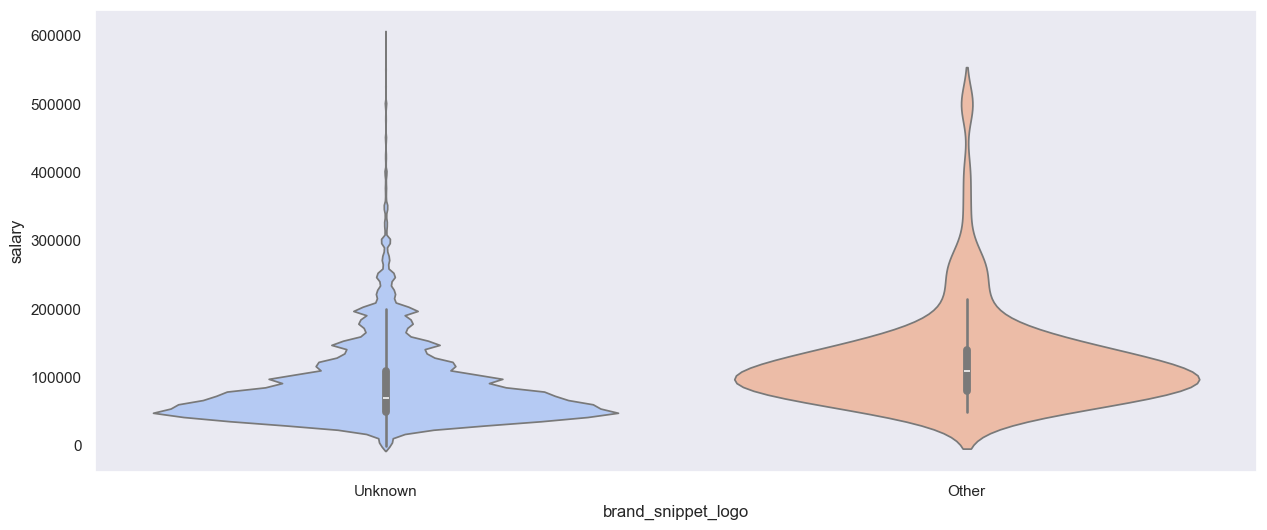

In [167]:
plt.figure(figsize = (15, 6))
sns.violinplot(
    x = df[df['salary'] < percentile_99]['brand_snippet_logo'],
    y = df[df['salary'] < percentile_99]['salary'],
    split = False,
    palette = "coolwarm"
)
plt.show()

In [169]:
group1 = df[df['brand_snippet_logo'] == 'Unknown']['salary']
group2 = df[df['brand_snippet_logo'] == 'Other']['salary']
t_stat, t_p_value = ttest_ind(group1, group2)
print(f"T-тест: статистика = {t_stat}, p-значение = {t_p_value}")

alpha = 0.05
if t_p_value < alpha:
    print("Отклоняем нулевую гипотезу: Средние значения зарплат отличаются.")
else:
    print("Не имеем оснований отклонить нулевую гипотезу: Средние значения зарплат равны.")

T-тест: статистика = -4.27319911371744, p-значение = 1.9271331394497228e-05
Отклоняем нулевую гипотезу: Средние значения зарплат отличаются.


## Колонка brand_snippet_picture

In [171]:
df['brand_snippet_picture'].unique()

array(['Unknown', 'https://hhcdn.ru/file/17878288.png',
       'https://hhcdn.ru/file/17799889.png',
       'https://hhcdn.ru/file/17836746.png',
       'https://hhcdn.ru/file/17813881.png',
       'https://hhcdn.ru/file/17831430.png',
       'https://hhcdn.ru/file/17885270.png',
       'https://hhcdn.ru/file/17870997.png'], dtype=object)

In [172]:
df['brand_snippet_picture'] = df['brand_snippet_picture'].apply(lambda x: x if x == 'Unknown' else 'Other')

df['brand_snippet_picture'].unique()

array(['Unknown', 'Other'], dtype=object)

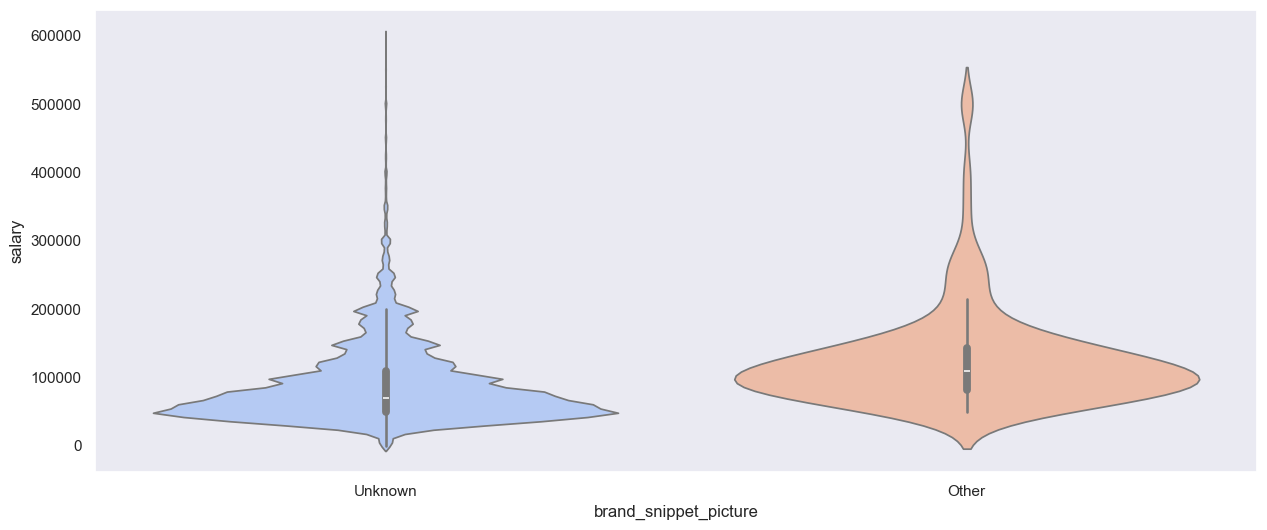

In [173]:
plt.figure(figsize = (15, 6))
sns.violinplot(
    x = df[df['salary'] < percentile_99]['brand_snippet_picture'],
    y = df[df['salary'] < percentile_99]['salary'],
    split = False,
    palette = "coolwarm"
)
plt.show()

In [174]:
group1 = df[df['brand_snippet_picture'] == 'Unknown']['salary']
group2 = df[df['brand_snippet_picture'] == 'Other']['salary']
t_stat, t_p_value = ttest_ind(group1, group2)
print(f"T-тест: статистика = {t_stat}, p-значение = {t_p_value}")

alpha = 0.05
if t_p_value < alpha:
    print("Отклоняем нулевую гипотезу: Средние значения зарплат отличаются.")
else:
    print("Не имеем оснований отклонить нулевую гипотезу: Средние значения зарплат равны.")

T-тест: статистика = -4.320652709593761, p-значение = 1.5558946204965328e-05
Отклоняем нулевую гипотезу: Средние значения зарплат отличаются.


## Колонка brand_snippet_background_color

In [176]:
df['brand_snippet_background_color'].unique()

array(['Unknown', '#EF3124', '#124F2E', '#FF5B29'], dtype=object)

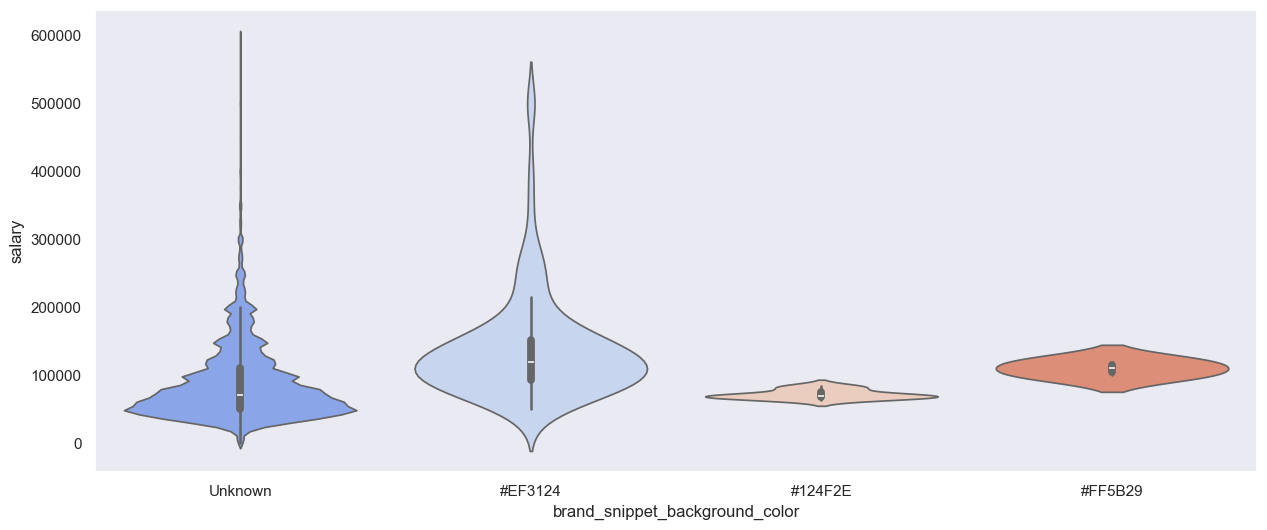

In [178]:
plt.figure(figsize = (15, 6))
sns.violinplot(
    x = df[df['salary'] < percentile_99]['brand_snippet_background_color'],
    y = df[df['salary'] < percentile_99]['salary'],
    split = False,
    palette = "coolwarm"
)
plt.show()

In [181]:
salary_groups = [group['salary'].values for _, group in filtered_df.groupby('brand_snippet_background_color')]
statistic, p_value = kruskal(*salary_groups)

print(f'Статистика Краскела-Уоллиса: {statistic}')
print(f'P-value: {p_value}')

if p_value < 0.05:
    print('Существует статистически значимая зависимость между цветом фона и зарплатой')
else:
    print('Нет статистически значимой зависимости между цветом фона и зарплатой')

Статистика Краскела-Уоллиса: 16.787434667539426
P-value: 0.00022628453780117232
Существует статистически значимая зависимость между цветом фона и зарплатой


## Колонка brand_snippet_background_gradient_angle

In [177]:
df['brand_snippet_background_gradient_angle'].unique()

array(['Unknown', 200.0, 0.0, 134.0, 206.43, 67.0], dtype=object)

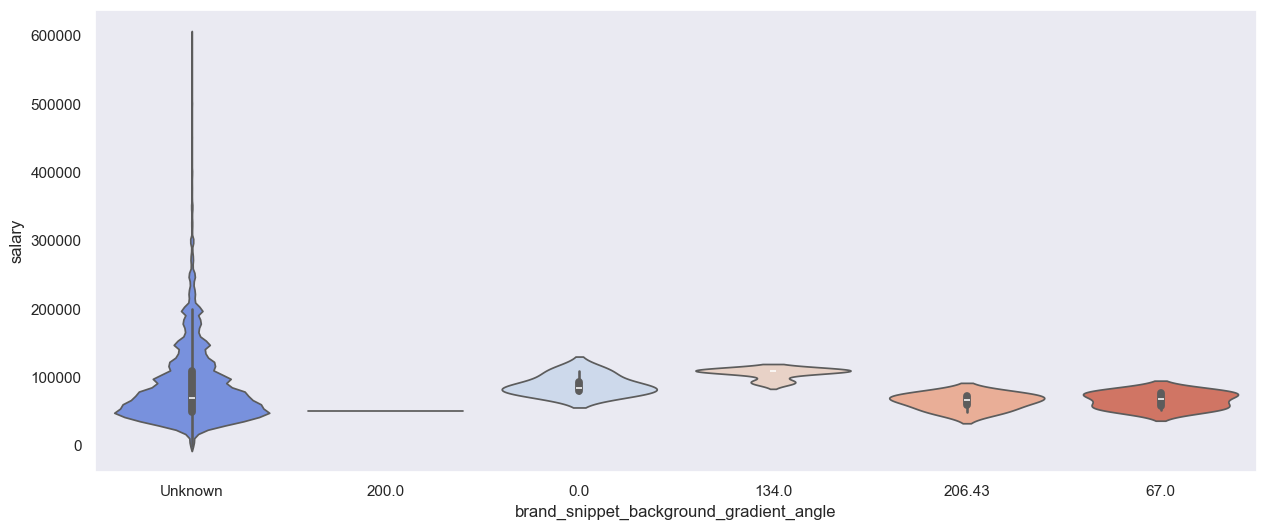

In [184]:
plt.figure(figsize = (15, 6))
sns.violinplot(
    x = df[df['salary'] < percentile_99]['brand_snippet_background_gradient_angle'],
    y = df[df['salary'] < percentile_99]['salary'],
    split = False,
    palette = "coolwarm"
)
plt.show()

In [185]:
salary_groups = [group['salary'].values for _, group in filtered_df.groupby('brand_snippet_background_gradient_angle')]
statistic, p_value = kruskal(*salary_groups)

print(f'Статистика Краскела-Уоллиса: {statistic}')
print(f'P-value: {p_value}')

if p_value < 0.05:
    print('Существует статистически значимая зависимость между углом градиента фона и зарплатой')
else:
    print('Нет статистически значимой зависимости между углом градиента фона и зарплатой')

Статистика Краскела-Уоллиса: 20.852710925086242
P-value: 0.0003386874362879603
Существует статистически значимая зависимость между углом градиента фона и зарплатой


## Колонка brand_snippet_background_gradient_color_list_0_color

In [192]:
df['brand_snippet_background_gradient_color_list_0_color'].unique()

array(['Unknown', '#06B6D9', '#FC8507', '#DFC365', '#50ACFF', '#06B5F8'],
      dtype=object)

In [194]:
del df['brand_snippet_background_gradient_color_list_0_color']

## Колонка brand_snippet_background_gradient_color_list_1_color

In [193]:
df['brand_snippet_background_gradient_color_list_1_color'].unique()

array(['Unknown', '#006C9B', '#FFA218', '#55CBC0', '#108EFF', '#42E3B4'],
      dtype=object)

In [195]:
del df['brand_snippet_background_gradient_color_list_1_color']

## Колонки immediate_redirect_url и immediate_redirect_vacancy_id

In [191]:
df['immediate_redirect_url'].unique()

6

In [188]:
nan_department_name = df['immediate_redirect_url'].isna().sum()
print(f'Колчиество NaN объектов: {nan_department_name}')

Колчиество NaN объектов: 709148


In [ ]:
del df['immediate_redirect_url']

In [187]:
df['immediate_redirect_vacancy_id'].unique()

array([           nan, 1.07230633e+08, 1.05391712e+08])

In [189]:
nan_department_name = df['immediate_redirect_vacancy_id'].isna().sum()
print(f'Колчиество NaN объектов: {nan_department_name}')

Колчиество NaN объектов: 709566


In [ ]:
del df['immediate_redirect_vacancy_id']